In [5]:
# Paso 1: Importación de bibliotecas
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import kendalltau, pointbiserialr

# Integración de Weka (segura)
try:
    import weka.core.jvm as jvm
    from weka.core.converters import Loader
    from weka.classifiers import Classifier, Evaluation
    from weka.core.classes import Random
    weka_available = True
except:
    weka_available = False

# Integración de R (segura)
"""
try:
    import rpy2.robjects as ro
    from rpy2.robjects import pandas2ri
    pandas2ri.activate()
    r_available = True
except:
    r_available = False
"""



'\ntry:\n    import rpy2.robjects as ro\n    from rpy2.robjects import pandas2ri\n    pandas2ri.activate()\n    r_available = True\nexcept:\n    r_available = False\n'

c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [15:03:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


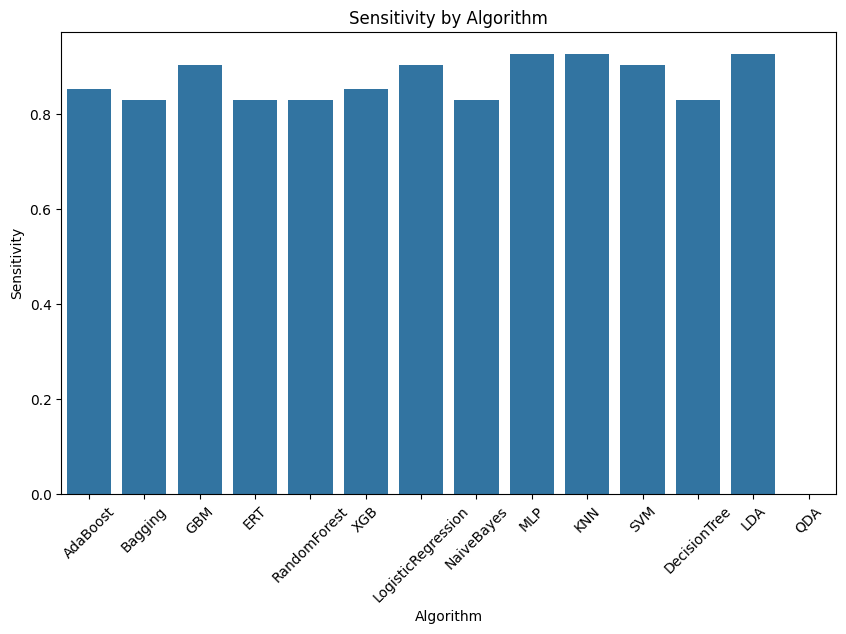

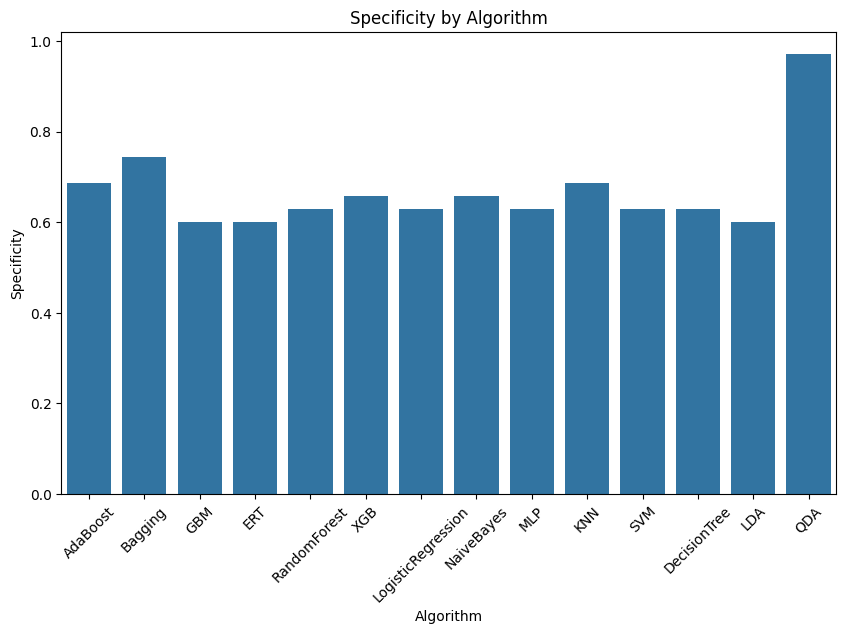

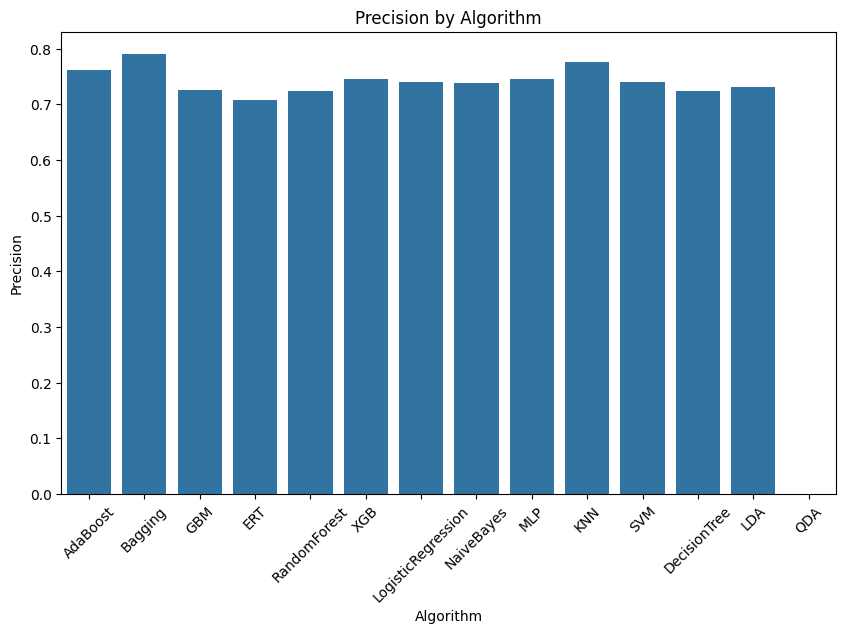

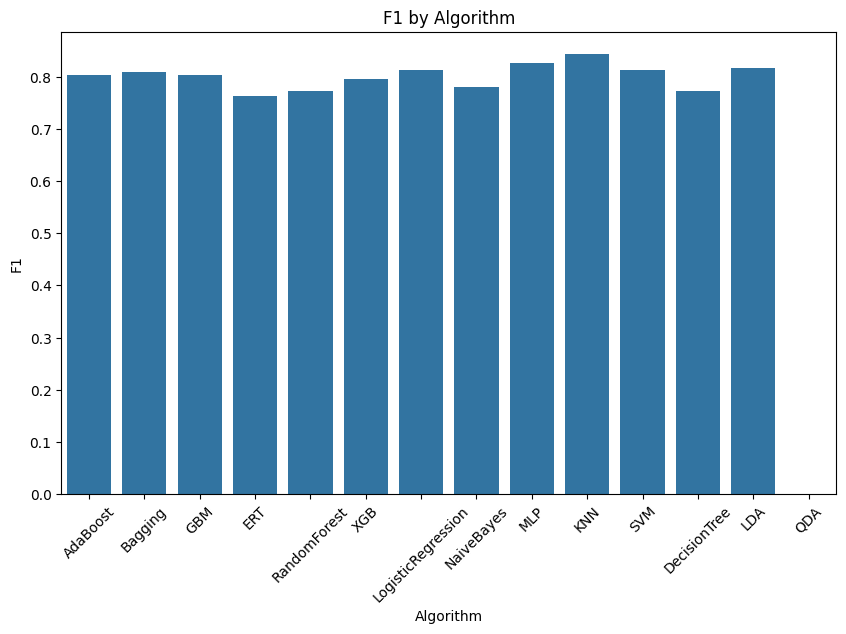

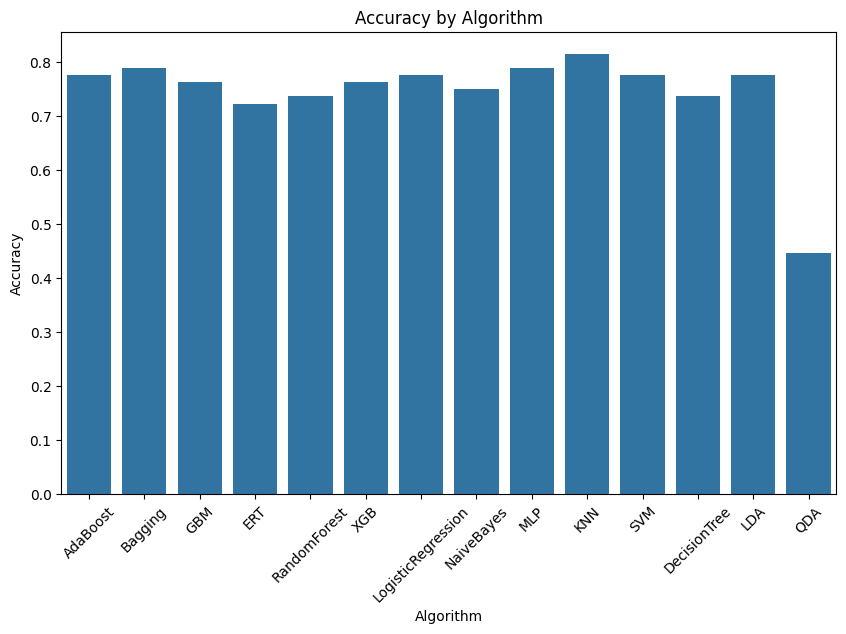

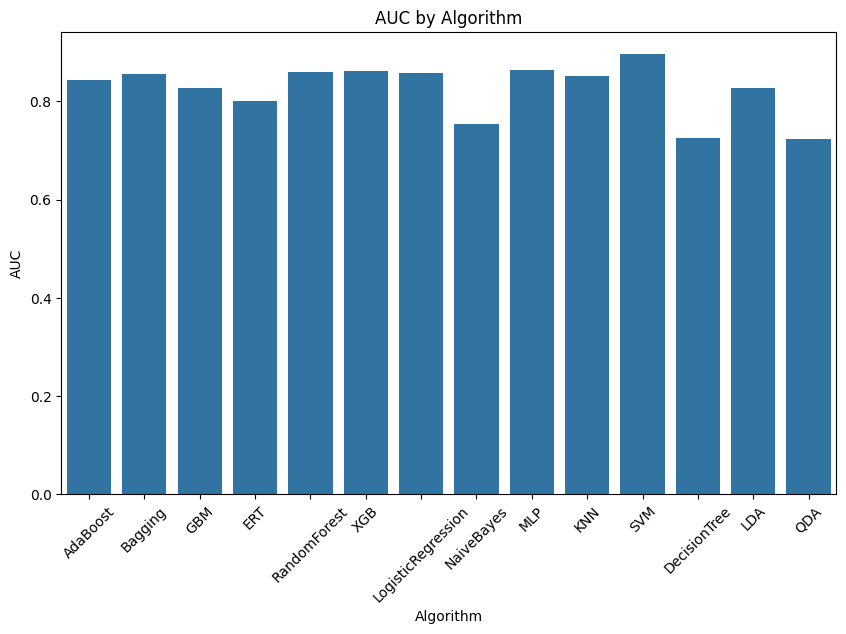

In [7]:
# Paso 2: Carga de datos y preprocesamiento
df = pd.read_csv("heart.csv")

# Convertir columnas a categóricas
categorical_columns = ['sex', 'cp', 'fbs', 'exang', 'restecg', 'slope', 'thal', 'target']
df[categorical_columns] = df[categorical_columns].astype('category')

# Renombrar categorías comunes
df['sex'] = df['sex'].cat.rename_categories(['Female', 'Male'])
df['fbs'] = df['fbs'].cat.rename_categories(['Fasting Blood Sugar <= 120', 'Fasting Blood Sugar > 120'])
df['exang'] = df['exang'].cat.rename_categories(['No Exercise Induced Angina', 'Exercise Induced Angina'])
df['cp'] = df['cp'].cat.rename_categories(['Chest Pain Type 0', 'Chest Pain Type 1', 'Chest Pain Type 2', 'Chest Pain Type 3'])
df['restecg'] = df['restecg'].cat.rename_categories(['Rest ECG 0', 'Rest ECG 1', 'Rest ECG 2'])
df['slope'] = df['slope'].cat.rename_categories(['Peak Excercise ST Slope 0', 'Peak Excercise ST Slope 1', 'Peak Excercise ST Slope 2'])
df['target'] = df['target'].cat.rename_categories(['Healthy', 'Heart Disease'])

# --- Manejo especial de thal (detecta versión del dataset) ---
thal_cats = df['thal'].cat.categories.tolist()
if set(thal_cats) == {0,1,2,3}:
    df['thal'] = df['thal'].cat.rename_categories(['No Thalassemia','Normal','Fixed Defect','Reversible Defect'])
elif set(thal_cats) == {1,2,3}:
    df['thal'] = df['thal'].cat.rename_categories(['Normal','Fixed Defect','Reversible Defect'])
elif set(thal_cats) == {3,6,7}:
    df['thal'] = df['thal'].cat.rename_categories({3:'Normal',6:'Fixed Defect',7:'Reversible Defect'})
else:
    print("⚠️ thal tiene categorías inesperadas:", thal_cats)

# Copia para visualización
df_vis = df.copy()

# Variables seleccionadas
best_33 = ['cp', 'thal', 'oldpeak', 'target']
if 'ca' in df.columns:   # solo usar si existe
    best_33.insert(2, 'ca')

df = df[best_33].copy()

# Paso 3: convertir target a numérico
df['target'] = df['target'].cat.codes

# One-hot y división
y = df['target']
X = pd.get_dummies(df.drop('target', axis=1), drop_first=True).astype('float64')

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Paso 4: Métricas
def metricas(model, model_label, X_train, X_valid, y_train, y_valid):
    y_pred = model.predict(X_valid)
    try:
        y_pred_prob = model.predict_proba(X_valid)[:, 1]
    except AttributeError:
        y_pred_prob = y_pred

    cm = confusion_matrix(y_valid, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = recall_score(y_valid, y_pred)
    specificity = tn / (tn + fp)
    precision = precision_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    accuracy = accuracy_score(y_valid, y_pred)
    try:
        auc = roc_auc_score(y_valid, y_pred_prob)
    except:
        auc = np.nan

    return {
        'Algorithm': model_label,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'F1': f1,
        'Accuracy': accuracy,
        'AUC': auc
    }

# Paso 5: Modelos
models = {
    'AdaBoost': AdaBoostClassifier(),
    'Bagging': BaggingClassifier(),
    'GBM': GradientBoostingClassifier(),
    'ERT': ExtraTreesClassifier(),
    'RandomForest': RandomForestClassifier(),
    'XGB': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'NaiveBayes': GaussianNB(),
    'MLP': MLPClassifier(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'DecisionTree': DecisionTreeClassifier(),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis()    
}

# Entrenar modelos
results = []
X_train_np = np.ascontiguousarray(X_train.values)
X_valid_np = np.ascontiguousarray(X_valid.values)

for model_label, model in models.items():
    model.fit(X_train_np, y_train)
    result = metricas(model, model_label, X_train_np, X_valid_np, y_train, y_valid)
    results.append(result)

df_results = pd.DataFrame(results)

# Paso 6: Visualización
metrics = ['Sensitivity', 'Specificity', 'Precision', 'F1', 'Accuracy', 'AUC']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Algorithm', y=metric, data=df_results)  # 👉 cambiado a barplot (porque solo 1 valor por modelo)
    plt.title(f'{metric} by Algorithm')
    plt.xticks(rotation=45)
    plt.show()


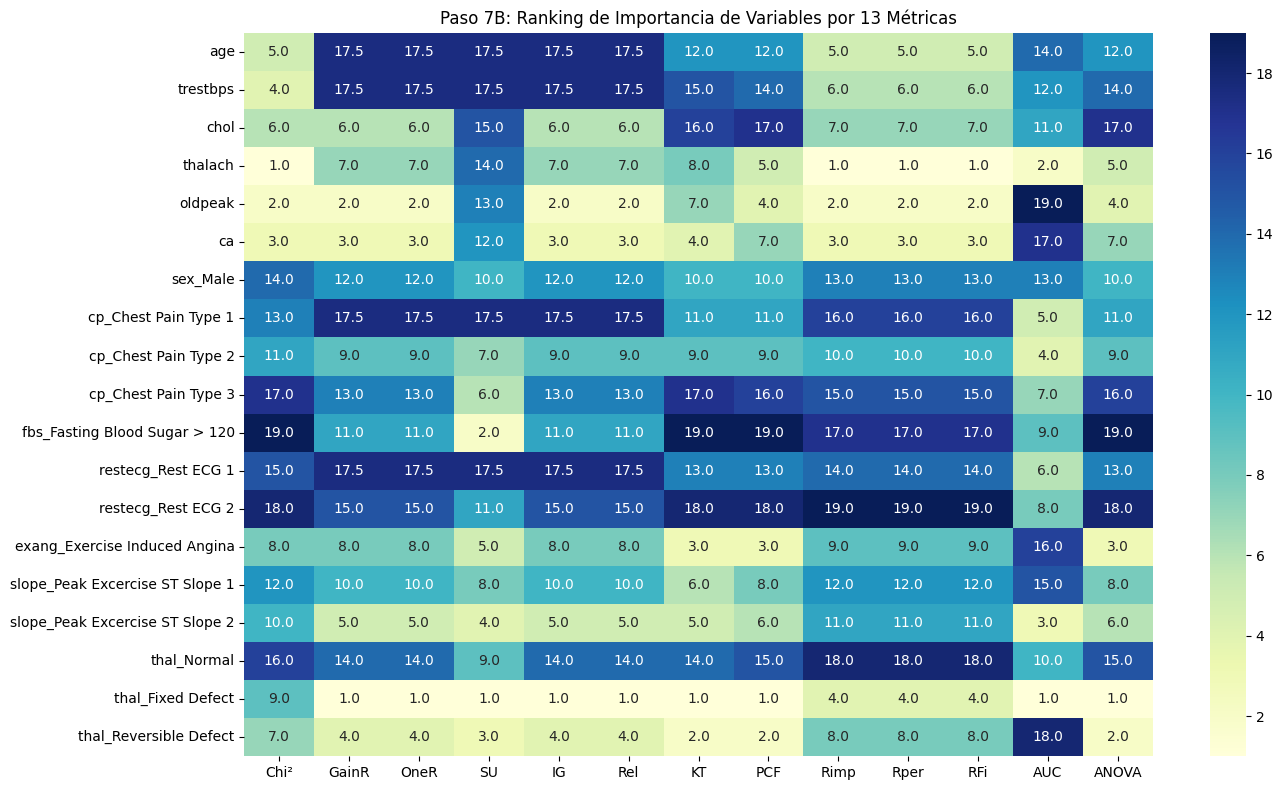

                                 Chi²  GainR  OneR    SU    IG   Rel    KT  \
thal_Fixed Defect                 9.0    1.0   1.0   1.0   1.0   1.0   1.0   
oldpeak                           2.0    2.0   2.0  13.0   2.0   2.0   7.0   
thalach                           1.0    7.0   7.0  14.0   7.0   7.0   8.0   
ca                                3.0    3.0   3.0  12.0   3.0   3.0   4.0   
thal_Reversible Defect            7.0    4.0   4.0   3.0   4.0   4.0   2.0   
slope_Peak Excercise ST Slope 2  10.0    5.0   5.0   4.0   5.0   5.0   5.0   
exang_Exercise Induced Angina     8.0    8.0   8.0   5.0   8.0   8.0   3.0   
cp_Chest Pain Type 2             11.0    9.0   9.0   7.0   9.0   9.0   9.0   
chol                              6.0    6.0   6.0  15.0   6.0   6.0  16.0   
slope_Peak Excercise ST Slope 1  12.0   10.0  10.0   8.0  10.0  10.0   6.0   
sex_Male                         14.0   12.0  12.0  10.0  12.0  12.0  10.0   
age                               5.0   17.5  17.5  17.5  17.5  

In [9]:
# Paso 7: Importancia de las características

# Preparar datos desde df_vis (con target codificado)
df_importancia = df_vis.copy()
df_importancia['target'] = df_importancia['target'].astype('category').cat.codes

X_imp = pd.get_dummies(df_importancia.drop('target', axis=1), drop_first=True).astype('float64')
y_imp = df_importancia['target']

# Asegurar no-negatividad para Chi2 (shift si hay negativos)
X_chi2 = X_imp - X_imp.min()

# Métricas base
chi2_vals, _ = chi2(X_chi2, y_imp)
mi_vals = mutual_info_classif(X_imp, y_imp, random_state=42)
anova_vals, _ = f_classif(X_imp, y_imp)

# Random Forest Importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X_imp, y_imp)
rfi_vals = rf.feature_importances_

# AUC por variable (univariado)
auc_vals = []
for col in X_imp.columns:
    try:
        if len(X_imp[col].unique()) > 1:
            auc = roc_auc_score(y_imp, X_imp[col])
        else:
            auc = np.nan
    except:
        auc = np.nan
    auc_vals.append(auc)

# Kendall Tau
kt_vals = []
for col in X_imp.columns:
    try:
        kt_vals.append(abs(kendalltau(X_imp[col], y_imp).correlation))
    except:
        kt_vals.append(np.nan)

# PCF (punto biserial)
pcf_vals = []
for col in X_imp.columns:
    try:
        corr, _ = pointbiserialr(X_imp[col], y_imp)
        pcf_vals.append(abs(corr))
    except:
        pcf_vals.append(np.nan)

# Aproximaciones para GainR, OneR, SU, Rel, Rimp, Rper
gainr_vals = mi_vals
oner_vals = mi_vals
# Symmetrical Uncertainty: normalización de MI
su_vals = mi_vals / (X_imp.var().values + 1e-6)
rel_vals = mi_vals
rimp_vals = rfi_vals
rper_vals = rfi_vals

# Compilar en DataFrame
importancia_df = pd.DataFrame({
    'Chi²': chi2_vals,
    'GainR': gainr_vals,
    'OneR': oner_vals,
    'SU': su_vals,
    'IG': mi_vals,
    'Rel': rel_vals,
    'KT': kt_vals,
    'PCF': pcf_vals,
    'Rimp': rimp_vals,
    'Rper': rper_vals,
    'RFi': rfi_vals,
    'AUC': auc_vals,
    'ANOVA': anova_vals
}, index=X_imp.columns)

# Paso 7B: Ranking de 13 métricas de importancia
ranking_df = importancia_df.rank(ascending=False)
ranking_df['Mean'] = ranking_df.mean(axis=1)
ranking_df['Rank'] = ranking_df['Mean'].rank()

# Exportar a CSV (ruta relativa para mayor portabilidad)
output_path = "ranking_importancia_metricas.csv"
ranking_df.sort_values("Rank").to_csv(output_path, index=True)

# Visualización: heatmap de las métricas originales
plt.figure(figsize=(14, 8))
sns.heatmap(ranking_df[['Chi²','GainR','OneR','SU','IG','Rel','KT','PCF','Rimp','Rper','RFi','AUC','ANOVA']], 
            annot=True, cmap='YlGnBu', fmt=".1f")
plt.title("Paso 7B: Ranking de Importancia de Variables por 13 Métricas")
plt.tight_layout()
plt.show()

# Mostrar tabla ordenada por importancia
print(ranking_df.sort_values("Rank"))

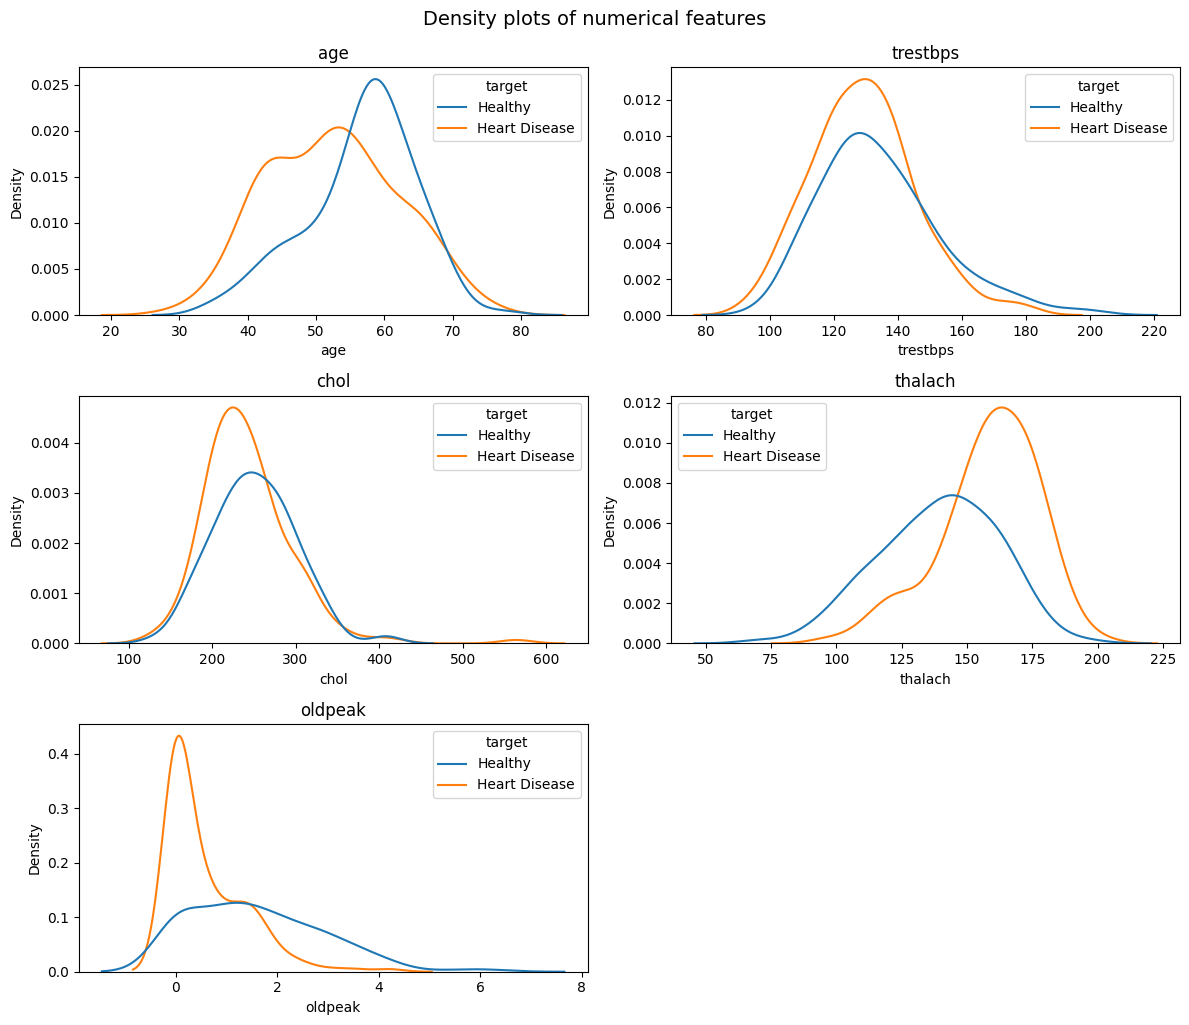

In [10]:
# Paso 7C: Gráficos de densidad de variables numéricas por clase

numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

plt.figure(figsize=(12, 10))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.kdeplot(data=df_vis, x=col, hue='target', fill=False)
    plt.title(col)

plt.tight_layout()
plt.suptitle("Density plots of numerical features", fontsize=14, y=1.02)
plt.show()


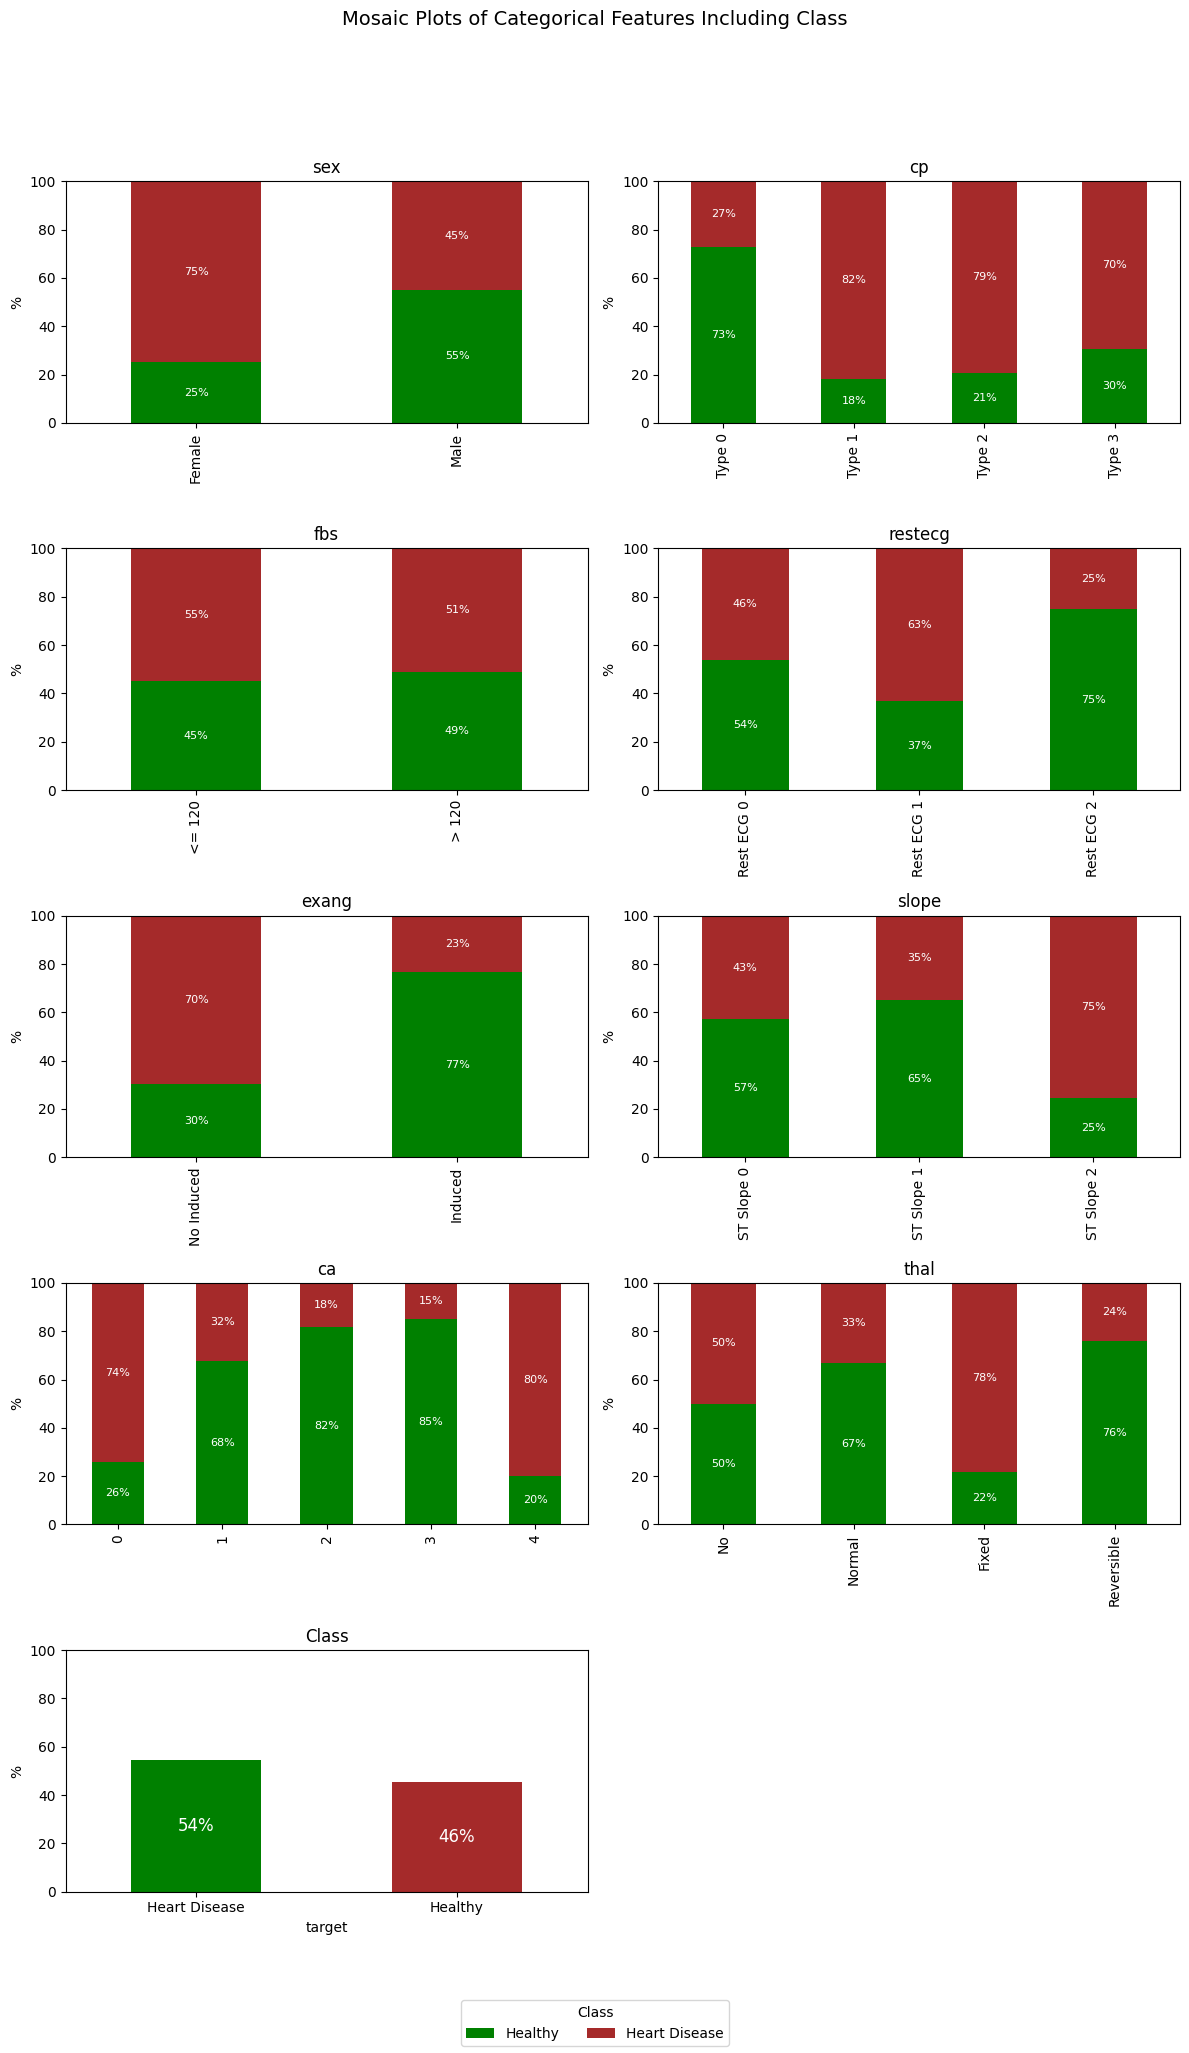

In [11]:
# Paso 7D: Gráficos de mosaico para variables categóricas incluyendo Class

# Recargar datos para asegurar que existan las columnas originales
categorical_columns_mosaic = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']
df_mosaic = pd.read_csv("heart.csv")
df_mosaic[categorical_columns_mosaic] = df_mosaic[categorical_columns_mosaic].astype('category')


# Renombrar niveles

try:
    df_mosaic['sex'] = df_mosaic['sex'].cat.rename_categories({0: 'Female', 1: 'Male'})
    df_mosaic['fbs'] = df_mosaic['fbs'].cat.rename_categories({0: '<= 120', 1: '> 120'})
    df_mosaic['thal'] = df_mosaic['thal'].cat.rename_categories({0: 'No', 1: 'Normal', 2: 'Fixed', 3: 'Reversible'})
    df_mosaic['target'] = df_mosaic['target'].cat.rename_categories({0: 'Healthy', 1: 'Heart Disease'})
    df_mosaic['exang'] = df_mosaic['exang'].cat.rename_categories({0: 'No Induced', 1: 'Induced'})
    df_mosaic['cp'] = df_mosaic['cp'].cat.rename_categories({0: 'Type 0', 1: 'Type 1', 2: 'Type 2', 3: 'Type 3'})
    df_mosaic['restecg'] = df_mosaic['restecg'].cat.rename_categories({0: 'Rest ECG 0', 1: 'Rest ECG 1', 2: 'Rest ECG 2'})
    df_mosaic['slope'] = df_mosaic['slope'].cat.rename_categories({0: 'ST Slope 0', 1: 'ST Slope 1', 2: 'ST Slope 2'})
except:
    pass

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 20))
axes = axes.flatten()

all_categories = categorical_columns_mosaic

for i, col in enumerate(all_categories):
    ax = axes[i]
    if col != 'target':
        prop_df = pd.crosstab(df_mosaic[col], df_mosaic['target'], normalize='index') * 100
        prop_df.plot(kind='bar', stacked=True, ax=ax, color=['green', 'brown'], legend=False)
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                ax.text(p.get_x() + p.get_width() / 2., p.get_y() + height / 2.,
                        f'{height:.0f}%', ha="center", va="center", color='white', fontsize=8)
        ax.set_title(col)
        ax.set_ylabel('%')
        ax.set_xlabel('')
        ax.set_ylim(0, 100)
    else:
        class_counts = df_mosaic['target'].value_counts(normalize=True) * 100
        class_counts.plot(kind='bar', color=['green', 'brown'], ax=ax)
        for j, v in enumerate(class_counts):
            ax.text(j, v / 2, f'{v:.0f}%', ha='center', va='center', color='white', fontsize=12)
        ax.set_title("Class")
        ax.set_ylabel('%')
        ax.set_xticklabels(class_counts.index, rotation=0)
        ax.set_ylim(0, 100)

for j in range(len(all_categories), len(axes)):
    fig.delaxes(axes[j])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Class", loc='lower center', ncol=2)
plt.suptitle('Mosaic Plots of Categorical Features Including Class', fontsize=14, y=1.02)
plt.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.show()


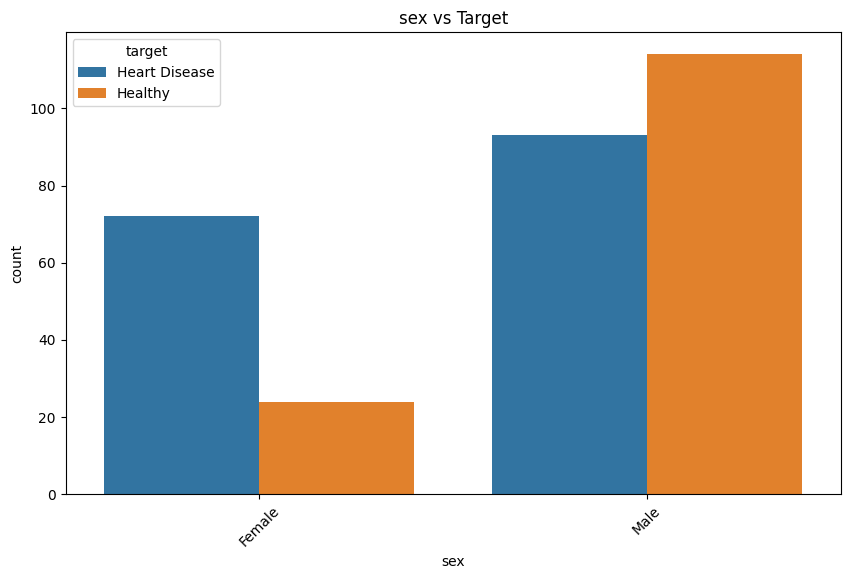

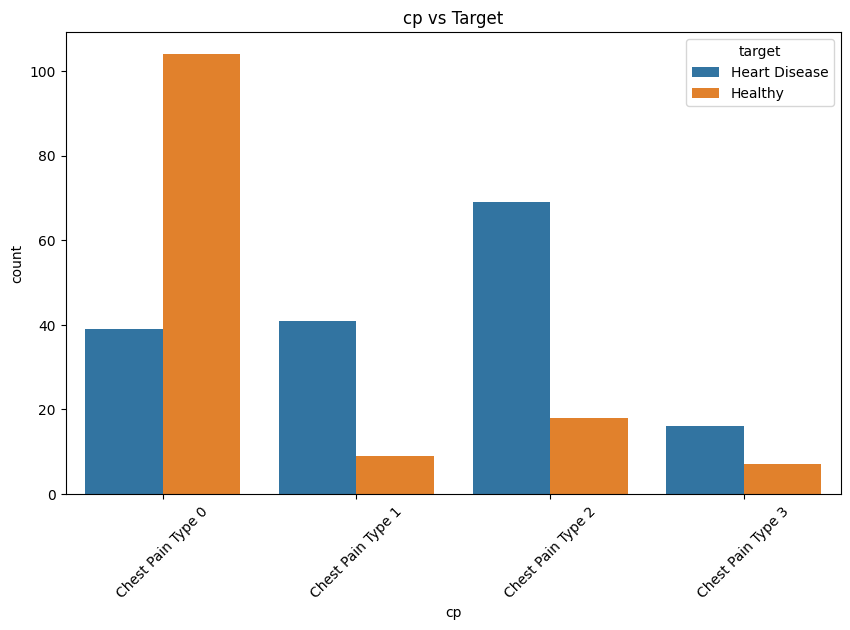

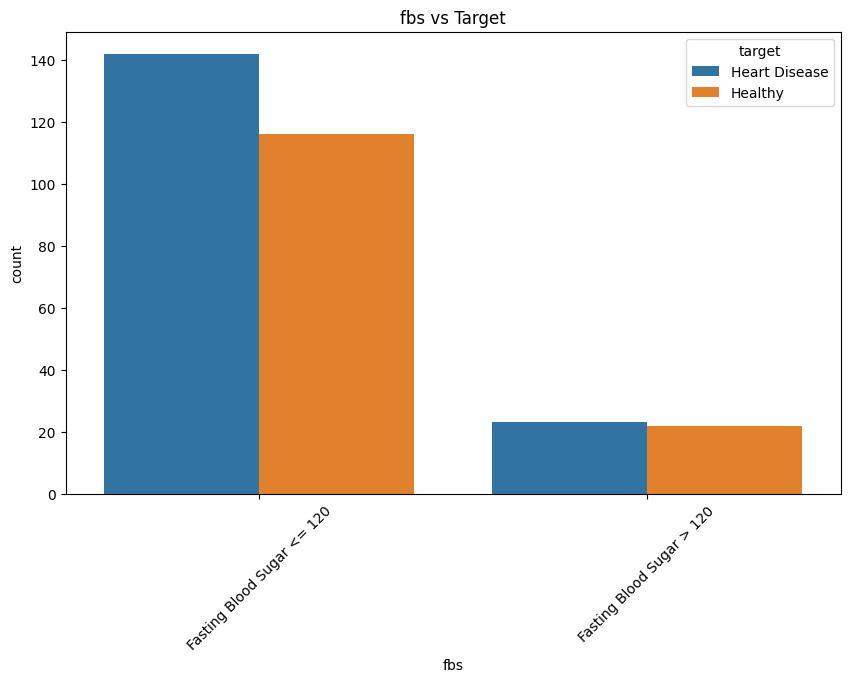

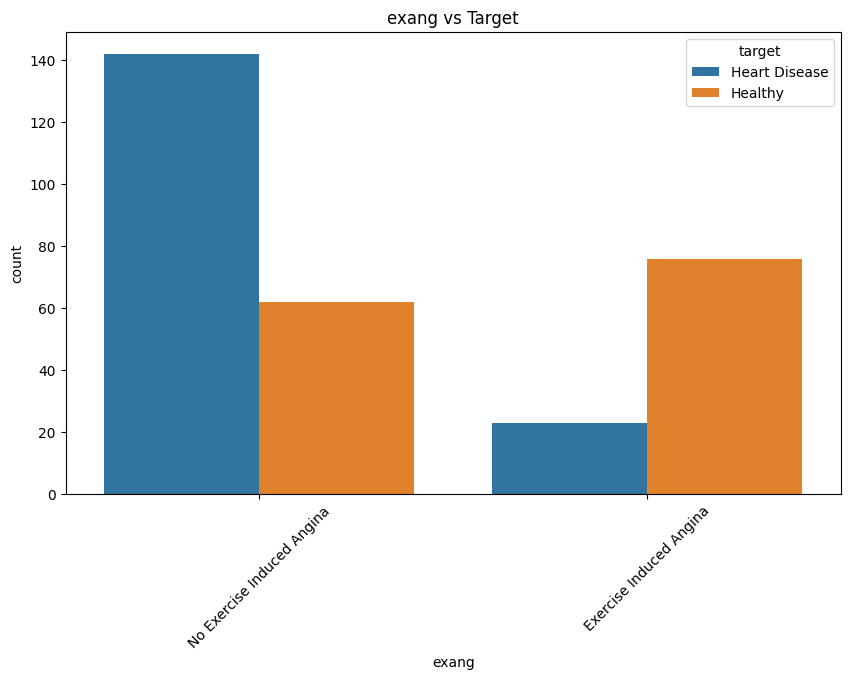

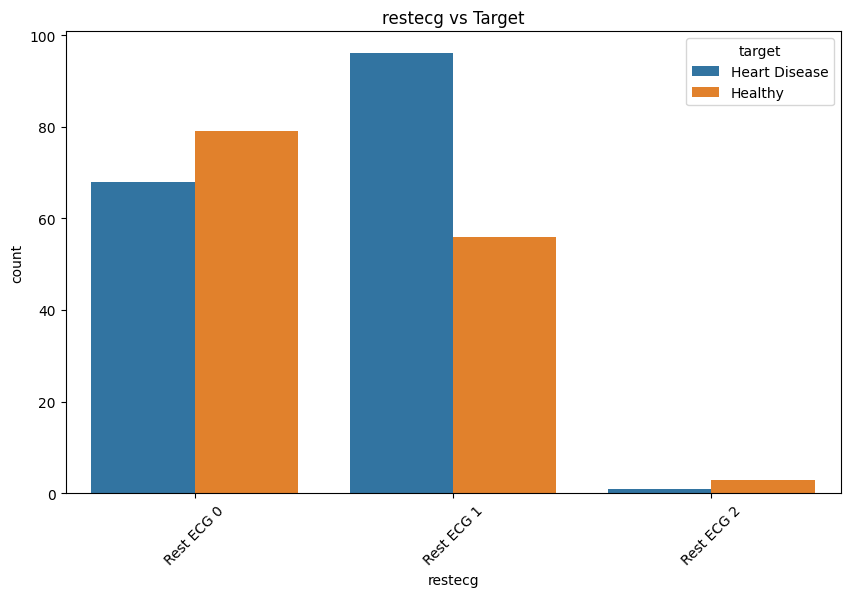

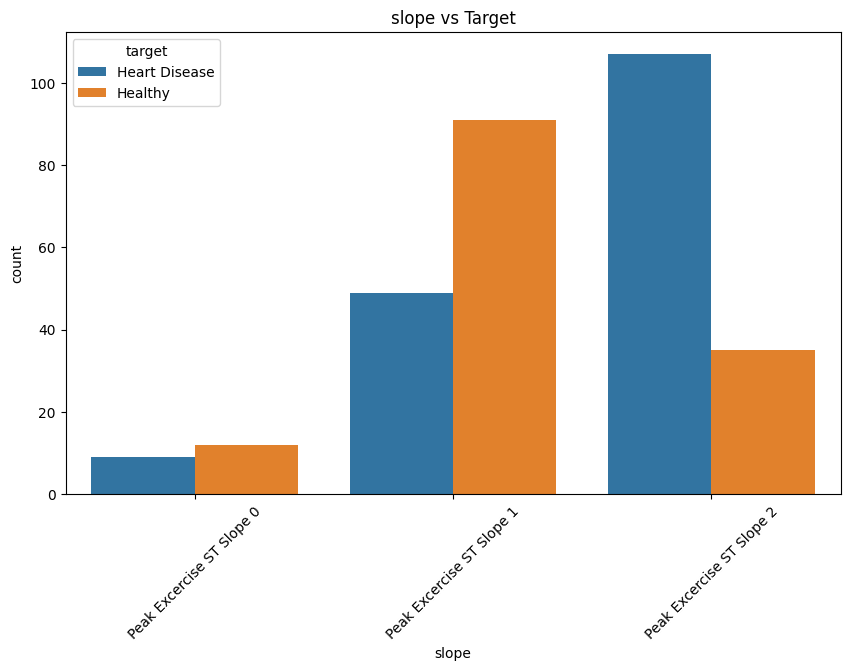

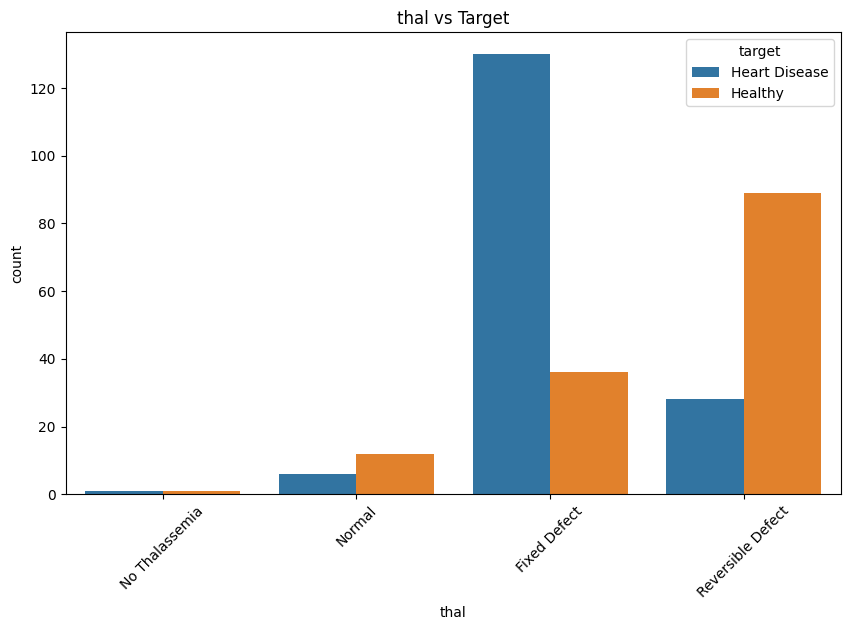

In [12]:
# Paso 8: Gráficos de variables pvs target 
df_vis['target'] = df_vis['target'].astype(str)
for col in categorical_columns:
    if col != 'target':
        plt.figure(figsize=(10, 6))
        sns.countplot(x=col, hue='target', data=df_vis)
        plt.title(f'{col} vs Target')
        plt.xticks(rotation=45)
        plt.show()


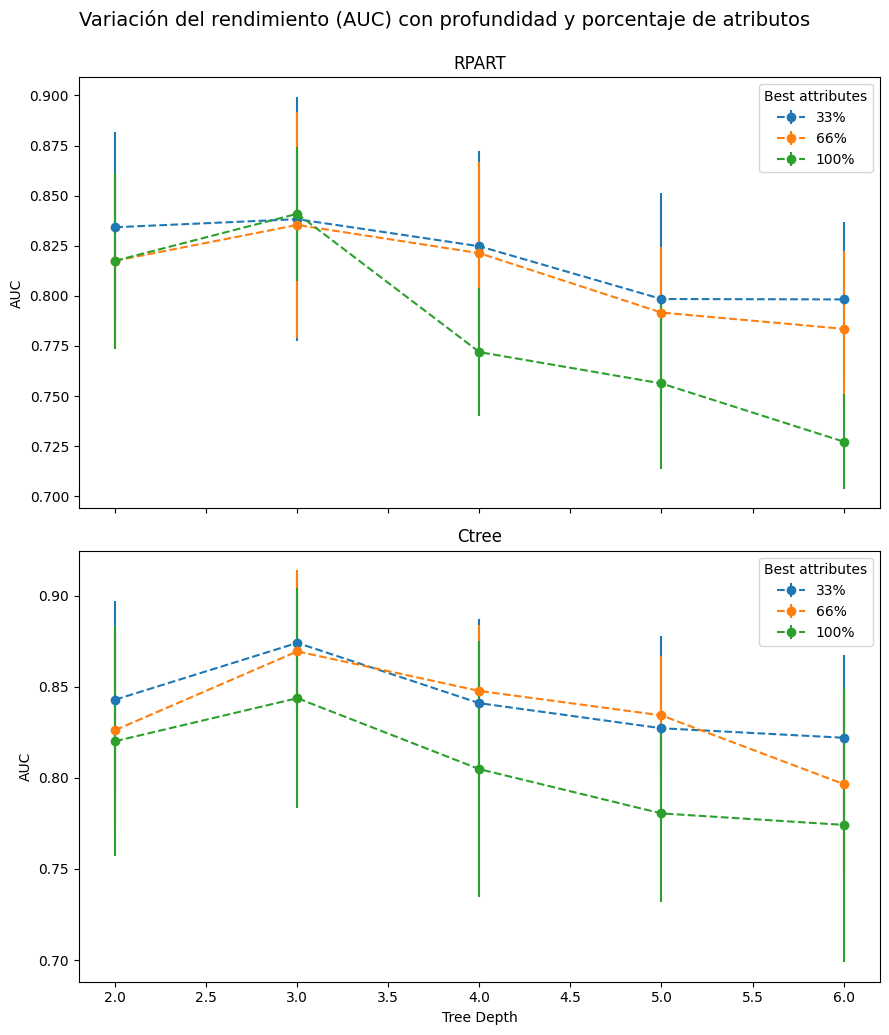

In [13]:
#paso 8.1: rendimiento (AUC) con profundidad y porcentaje de atributos
# Subconjuntos definidos
best_33 = ['cp', 'thal', 'ca', 'oldpeak', 'target']
best_66 = ['cp', 'thal', 'ca', 'oldpeak', 'thalach', 'exang', 'slope', 'sex', 'target']

df_33 = df_vis[best_33]
df_66 = df_vis[best_66]
df_100 = df_vis.copy()

attribute_sets = {
    '33%': df_33,
    '66%': df_66,
    '100%': df_100
}

depths = [2, 3, 4, 5, 6]
results_rpart = []
results_ctree = []

for name, dataset in attribute_sets.items():
    X = pd.get_dummies(dataset.drop('target', axis=1), drop_first=True).astype('float64')
    y = dataset['target'].astype('category').cat.codes

    for depth in depths:
        # RPART (gini)
        rpart = DecisionTreeClassifier(max_depth=depth, criterion='gini', random_state=42)
        rpart_scores = cross_val_score(rpart, X, y, cv=5, scoring='roc_auc')
        results_rpart.append({
            'Subset': name,
            'Depth': depth,
            'AUC': np.mean(rpart_scores),
            'Std': np.std(rpart_scores)
        })

        # Ctree (entropy)
        ctree = DecisionTreeClassifier(max_depth=depth, criterion='entropy', random_state=42)
        ctree_scores = cross_val_score(ctree, X, y, cv=5, scoring='roc_auc')
        results_ctree.append({
            'Subset': name,
            'Depth': depth,
            'AUC': np.mean(ctree_scores),
            'Std': np.std(ctree_scores)
        })

rpart_df = pd.DataFrame(results_rpart)
ctree_df = pd.DataFrame(results_ctree)

# Gráfica final
fig, axes = plt.subplots(2, 1, figsize=(9, 10), sharex=True)

for subset in rpart_df['Subset'].unique():
    data = rpart_df[rpart_df['Subset'] == subset]
    axes[0].errorbar(data['Depth'], data['AUC'], yerr=data['Std'], label=subset,
                     linestyle='dashed', marker='o')
axes[0].set_title("RPART")
axes[0].set_ylabel("AUC")
axes[0].legend(title="Best attributes")

for subset in ctree_df['Subset'].unique():
    data = ctree_df[ctree_df['Subset'] == subset]
    axes[1].errorbar(data['Depth'], data['AUC'], yerr=data['Std'], label=subset,
                     linestyle='dashed', marker='o')
axes[1].set_title("Ctree")
axes[1].set_xlabel("Tree Depth")
axes[1].set_ylabel("AUC")
axes[1].legend(title="Best attributes")

plt.tight_layout()
plt.suptitle("Variación del rendimiento (AUC) con profundidad y porcentaje de atributos", fontsize=14, y=1.03)
plt.show()



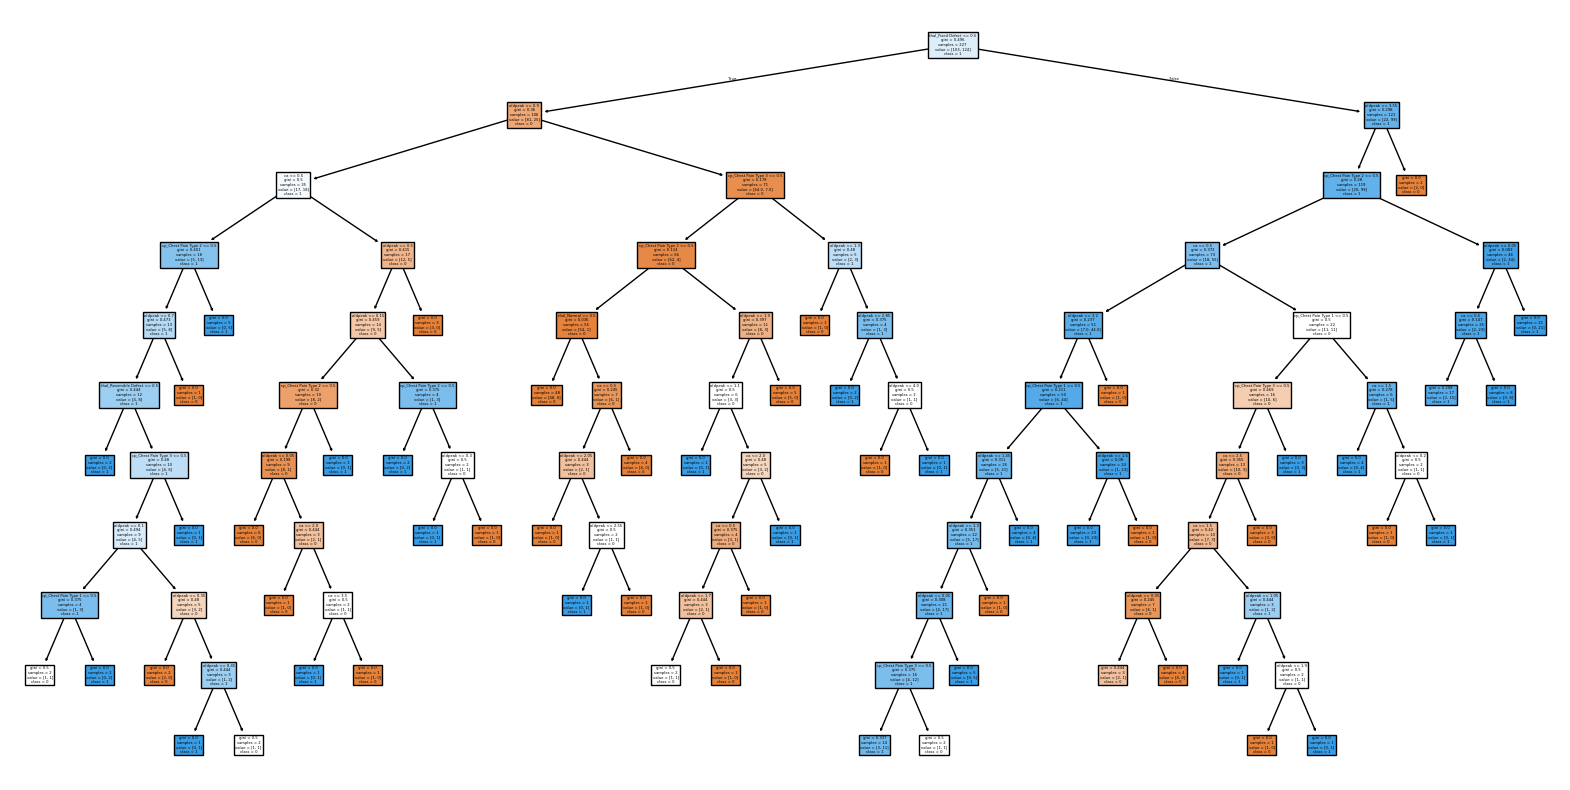

In [14]:
# Paso 9: Árbol de decisión
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=list(X_train.columns), class_names=['0', '1'])
plt.show()

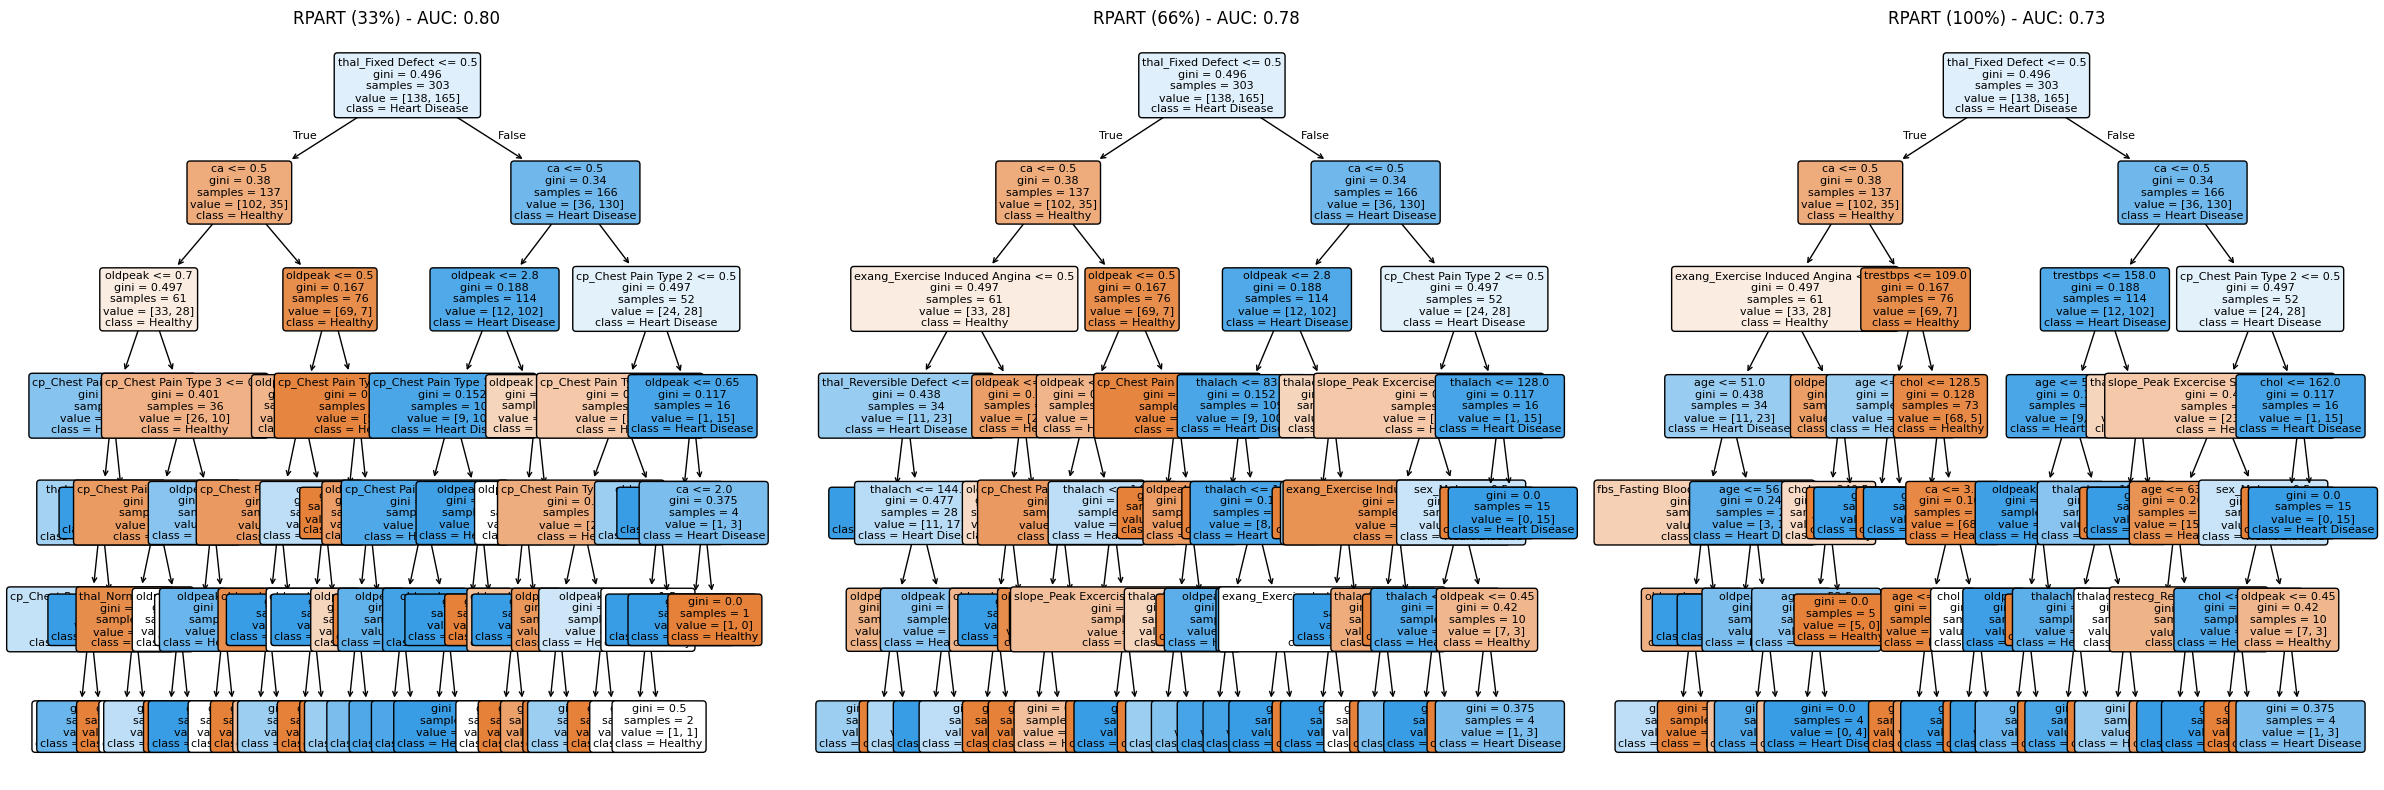

In [15]:
#Paso 9.1 Visualización de RPART con 33%, 66% y 100% de características (max_depth=6)


fig, axes = plt.subplots(1, 3, figsize=(24, 8))
attribute_sets = {
    '33%': df_33,
    '66%': df_66,
    '100%': df_100
}

rpart_auc_scores = {}

for ax, (name, dataset) in zip(axes, attribute_sets.items()):
    X = pd.get_dummies(dataset.drop('target', axis=1), drop_first=True).astype('float64')
    y = dataset['target'].astype('category').cat.codes

    model = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
    model.fit(X, y)

    auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc').mean()
    rpart_auc_scores[name] = auc

    plot_tree(
        model,
        feature_names=list(X.columns),
        class_names=['Healthy', 'Heart Disease'],
        filled=True,
        rounded=True,
        fontsize=8,
        ax=ax
    )
    ax.set_title(f"RPART ({name}) - AUC: {auc:.2f}")

plt.tight_layout()
plt.show()



In [16]:
from sklearn.tree import export_graphviz
import graphviz

# 33%
X_33 = pd.get_dummies(df_33.drop('target', axis=1), drop_first=True).astype('float64')
y_33 = df_33['target'].astype('category').cat.codes

model_33 = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
model_33.fit(X_33, y_33)

dot_data_33 = export_graphviz(
    model_33,
    out_file=None,
    feature_names=X_33.columns,
    class_names=['Healthy', 'Heart Disease'],
    filled=True,
    rounded=True,
    special_characters=True
)

graph_33 = graphviz.Source(dot_data_33)
graph_33.render("tree_33", format="png", cleanup=False)  # Exporta como PNG
graph_33.view()

'tree_33.pdf'

In [17]:
# 66%
X_66 = pd.get_dummies(df_66.drop('target', axis=1), drop_first=True).astype('float64')
y_66 = df_66['target'].astype('category').cat.codes

model_66 = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
model_66.fit(X_66, y_66)

dot_data_66 = export_graphviz(
    model_66,
    out_file=None,
    feature_names=X_66.columns,
    class_names=['Healthy', 'Heart Disease'],
    filled=True,
    rounded=True,
    special_characters=True
)

graph_66 = graphviz.Source(dot_data_66)
graph_66.render("tree_66", format="png", cleanup=False)
graph_66.view()

'tree_66.pdf'

In [18]:
from sklearn.tree import export_graphviz
import graphviz

# 100%
X_100 = pd.get_dummies(df_100.drop('target', axis=1), drop_first=True).astype('float64')
y_100 = df_100['target'].astype('category').cat.codes

# Reemplazar caracteres conflictivos en nombres de columnas
X_100.columns = X_100.columns.str.replace("&", "and").str.replace(">", "gt").str.replace("<", "lt")

model_100 = DecisionTreeClassifier(max_depth=6, criterion='gini', random_state=42)
model_100.fit(X_100, y_100)

dot_data_100 = export_graphviz(
    model_100,
    out_file=None,
    feature_names=X_100.columns,
    class_names=['Healthy', 'Heart Disease'],
    filled=True,
    rounded=True,
    special_characters=True
)

graph_100 = graphviz.Source(dot_data_100)
graph_100.render("tree_100", format="png", cleanup=False)
graph_100.view()

'tree_100.pdf'

c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [15:07:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [15:07:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [15:07:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [15:07:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

✅ df_results_all creado con validación cruzada para 33%, 66% y 100% de atributos
  Algorithm  Sensitivity  Specificity  Precision        F1  Accuracy  \
0  AdaBoost     0.848485     0.928571   0.933333  0.888889  0.885246   
1  AdaBoost     0.818182     0.821429   0.843750  0.830769  0.819672   
2  AdaBoost     0.909091     0.642857   0.750000  0.821918  0.786885   
3  AdaBoost     0.848485     0.814815   0.848485  0.848485  0.833333   
4  AdaBoost     0.848485     0.777778   0.823529  0.835821  0.816667   

        AUC attr  Fold  
0  0.957251   33     1  
1  0.922078   33     2  
2  0.851190   33     3  
3  0.927609   33     4  
4  0.913019   33     5  


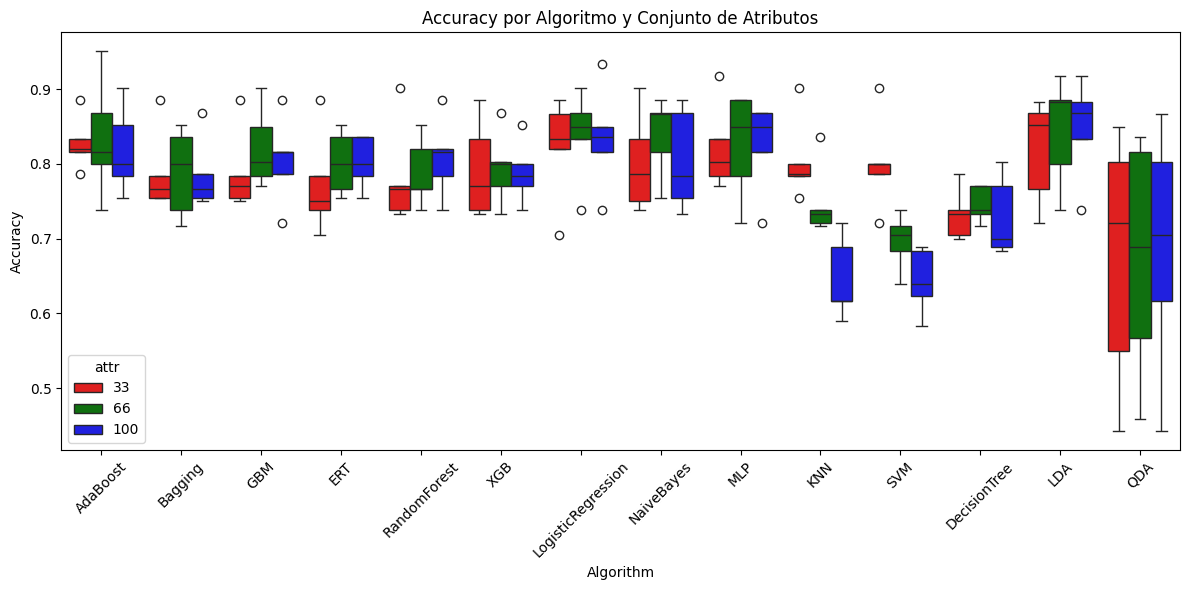

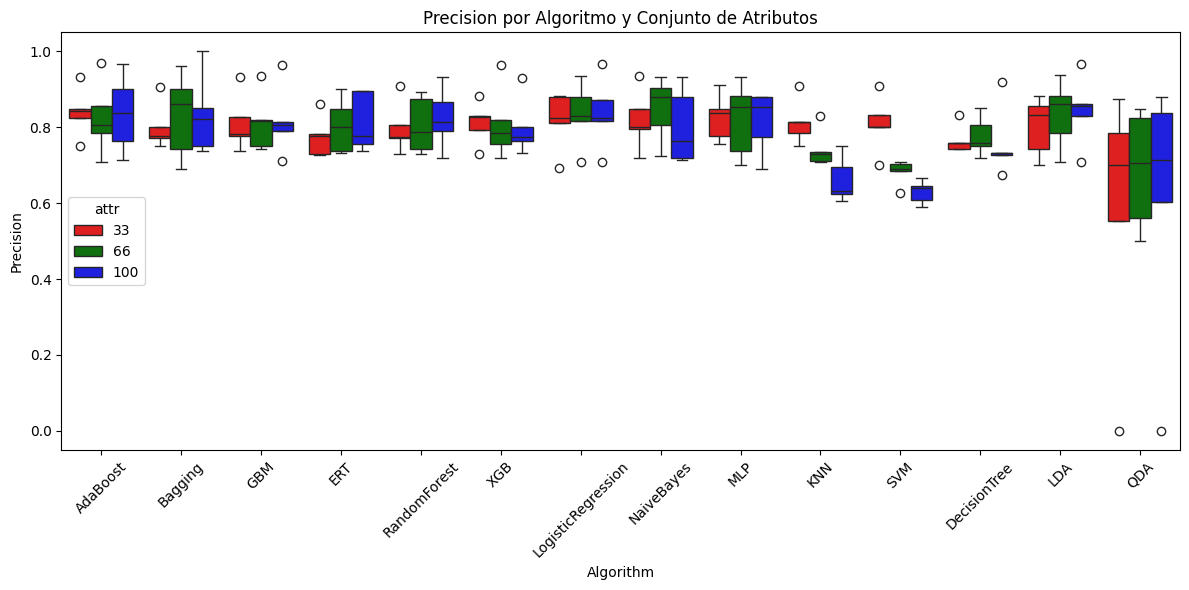

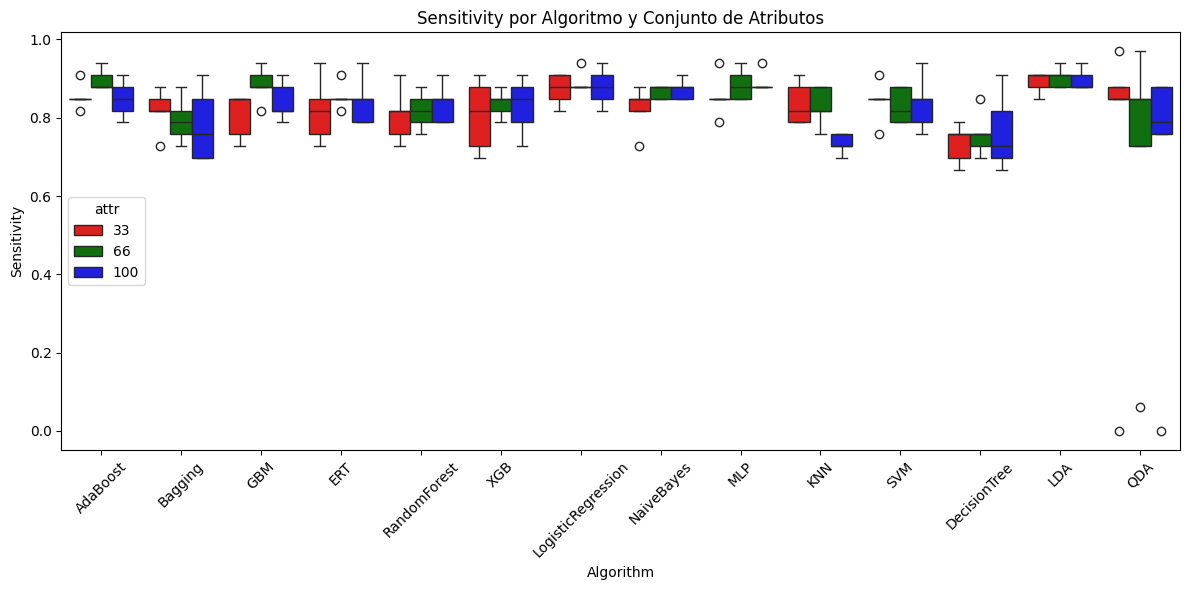

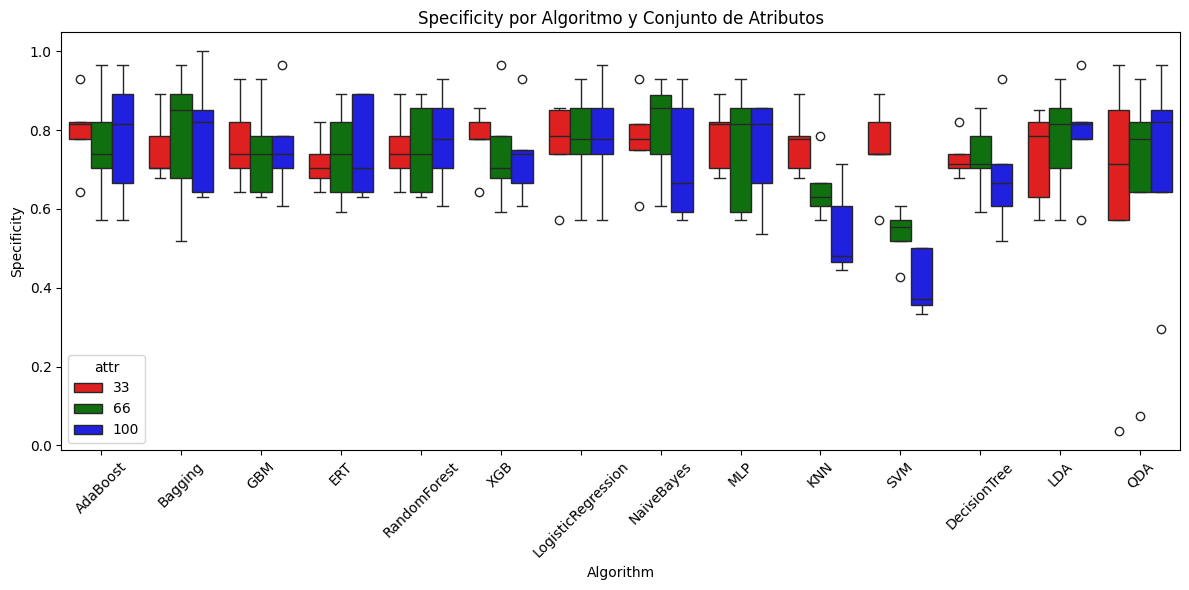

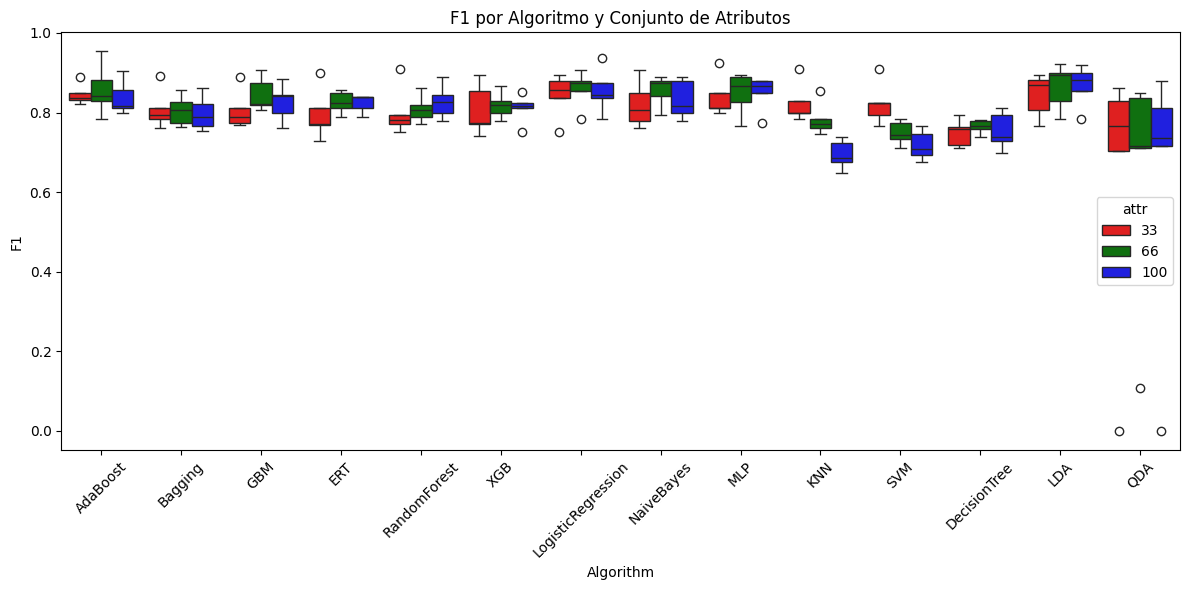

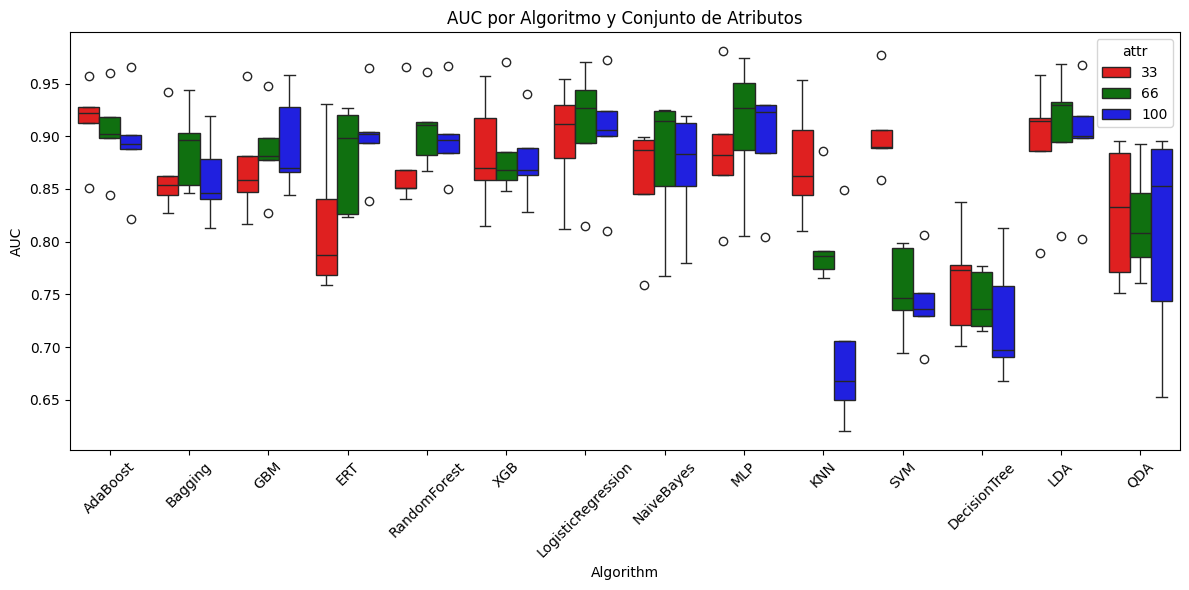

In [20]:
from sklearn.model_selection import StratifiedKFold

# Paso 10: Evaluación con conjuntos de datos distintos (33%, 66%, 100%)

# Definir subconjuntos de atributos
df_33 = df_vis[['cp', 'thal', 'ca', 'oldpeak', 'target']]
df_66 = df_vis[['cp', 'thal', 'ca', 'oldpeak', 'thalach', 'exang', 'slope', 'sex', 'target']]
df_100 = df_vis.copy()

datasets = {'33': df_33, '66': df_66, '100': df_100}
results_all = []

# Validación cruzada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, dataset in datasets.items():
    # Codificar target como 0/1
    y = dataset['target'].astype('category').cat.codes
    X = pd.get_dummies(dataset.drop('target', axis=1), drop_first=True).astype('float64')
    
    for model_label, model in models.items():
        fold_idx = 0
        for train_idx, test_idx in skf.split(X, y):
            fold_idx += 1
            X_train, X_valid = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_valid = y.iloc[train_idx], y.iloc[test_idx]

            model.fit(X_train, y_train)
            result = metricas(model, model_label, X_train, X_valid, y_train, y_valid)
            result['attr'] = name
            result['Fold'] = fold_idx
            results_all.append(result)

# Consolidar resultados
df_results_all = pd.DataFrame(results_all)

print("✅ df_results_all creado con validación cruzada para 33%, 66% y 100% de atributos")
print(df_results_all.head())

# Visualización
metrics = ['Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1', 'AUC']

for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Algorithm', y=metric, hue='attr', data=df_results_all,
                palette={'33': 'red', '66': 'green', '100': 'blue'})
    plt.title(f'{metric} por Algoritmo y Conjunto de Atributos')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [15:09:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [15:09:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [15:09:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\americasys\Desktop\nuevotest\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [15:09:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

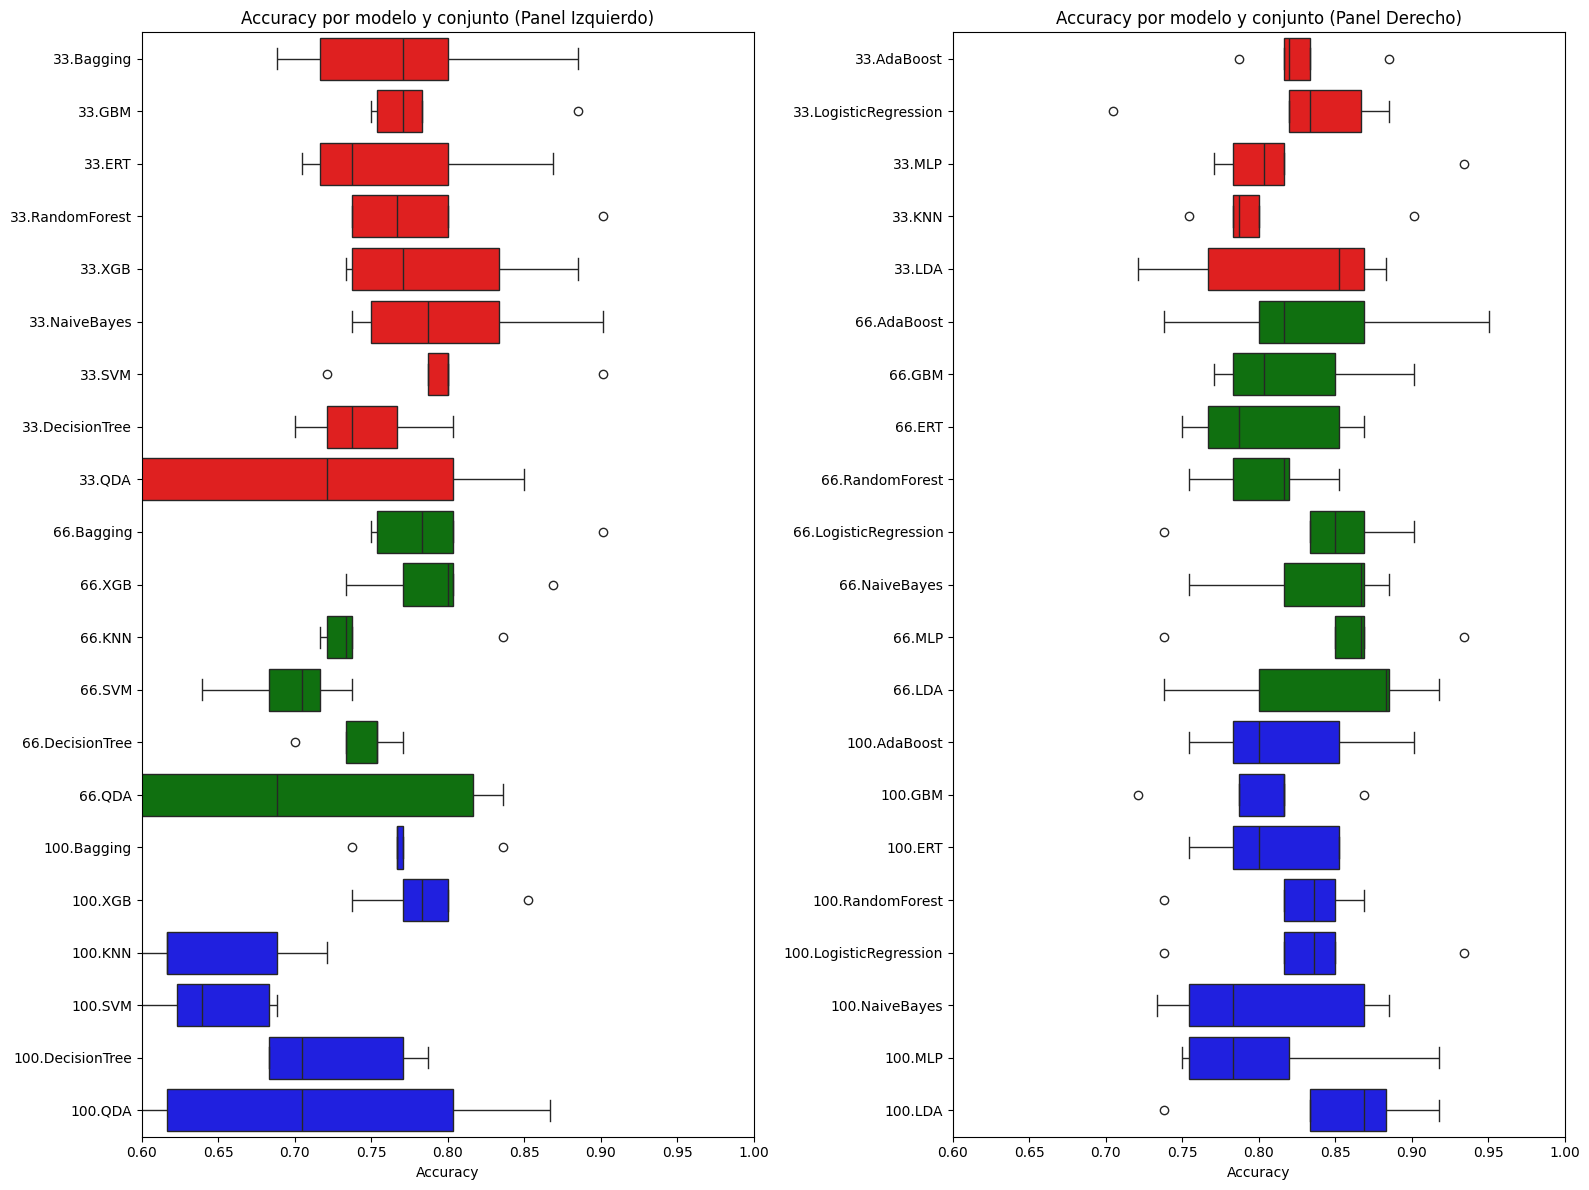

In [21]:
# Paso 10.1: Evaluación con conjuntos de datos distintos y visualización de Accuracy tipo boxplot (con CV)

from sklearn.model_selection import StratifiedKFold
import matplotlib.gridspec as gridspec

# Definir subconjuntos de atributos
df_33 = df_vis[best_33]
df_66 = df_vis[['cp', 'thal', 'ca', 'oldpeak', 'thalach', 'exang', 'slope', 'sex', 'target']]
df_100 = df_vis.copy()
datasets = {'33': df_33, '66': df_66, '100': df_100}

results_all = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, dataset in datasets.items():
    X = pd.get_dummies(dataset.drop('target', axis=1), drop_first=True).astype('float64')
    y = dataset['target'].astype('category').cat.codes

    for model_label, model in models.items():
        fold_idx = 0
        for train_idx, test_idx in skf.split(X, y):
            fold_idx += 1
            X_train, X_valid = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_valid = y.iloc[train_idx], y.iloc[test_idx]

            model.fit(X_train, y_train)
            result = metricas(model, model_label, X_train, X_valid, y_train, y_valid)
            result['attr'] = name
            result['Fold'] = fold_idx
            results_all.append(result)

# Crear DataFrame consolidado
df_results_all = pd.DataFrame(results_all)

# Crear clave de algoritmo + atributo para agrupamiento visual
df_results_all['Label'] = df_results_all['attr'] + '.' + df_results_all['Algorithm']
df_results_all['Color'] = df_results_all['attr'].map({'33': 'red', '66': 'green', '100': 'blue'})

# Gráfico tipo panel como la imagen de referencia
metric = 'Accuracy'
sorted_labels = df_results_all.groupby('Label')[metric].mean().sort_values().index

# Crear figura dividida en dos columnas
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
axs = [plt.subplot(gs[0]), plt.subplot(gs[1])]

half = len(sorted_labels) // 2

for i, ax in enumerate(axs):
    labels = sorted_labels[half*i:half*(i+1)]
    subset = df_results_all[df_results_all['Label'].isin(labels)]
    sns.boxplot(
        data=subset,
        y='Label',
        x=metric,
        hue='attr',
        orient='h',
        ax=ax,
        palette={'33': 'red', '66': 'green', '100': 'blue'}
    )
    ax.set_xlim(0.6, 1.0)  # rango más amplio para diferenciar
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('')
    ax.set_title(f'Accuracy por modelo y conjunto ({"Panel Izquierdo" if i == 0 else "Panel Derecho"})')
    ax.legend_.remove()

plt.tight_layout()
plt.show()


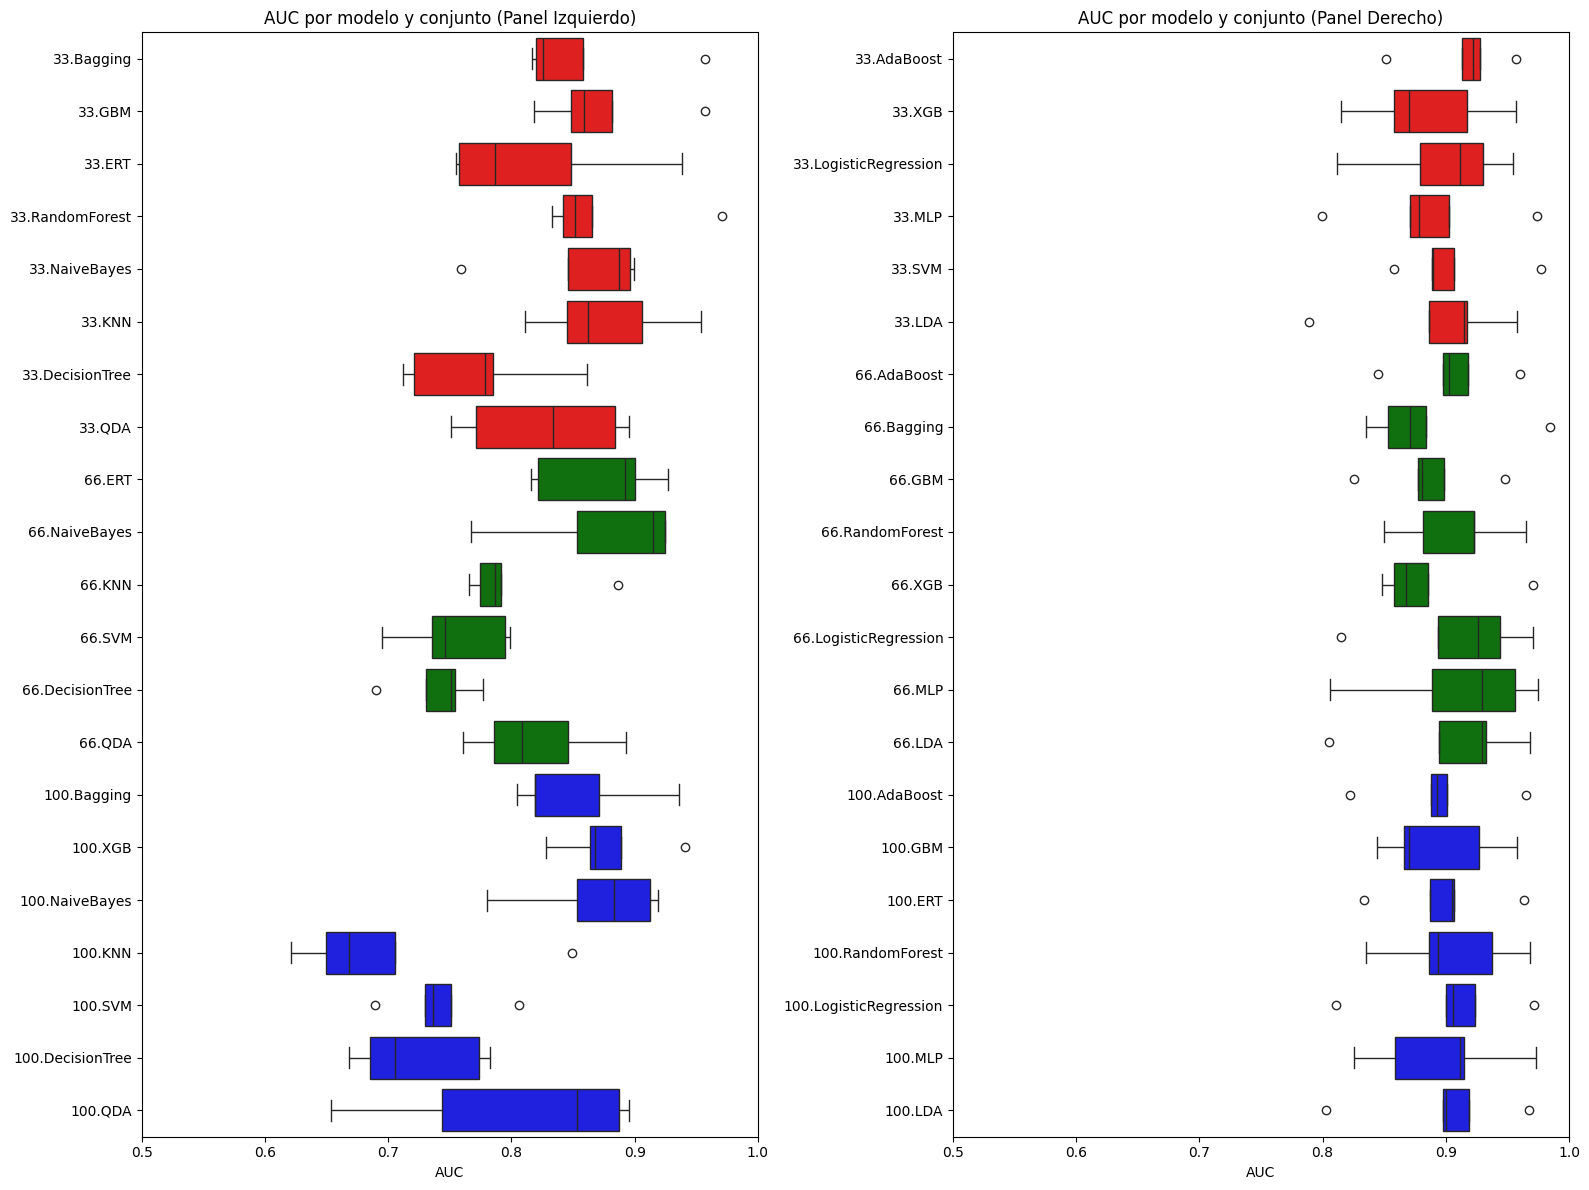

In [22]:
# ==========================
# Gráfico tipo panel para AUC por modelo y conjunto de datos
# ==========================

import matplotlib.gridspec as gridspec
import seaborn as sns
import matplotlib.pyplot as plt

# Asegurarse de que las columnas existan
if 'Label' not in df_results_all.columns:
    df_results_all['Label'] = df_results_all['attr'] + '.' + df_results_all['Algorithm']
if 'Color' not in df_results_all.columns:
    df_results_all['Color'] = df_results_all['attr'].map({'33': 'red', '66': 'green', '100': 'blue'})

# Definir métrica
metric = 'AUC'

# Verificar que la columna existe en el DataFrame
if metric not in df_results_all.columns:
    raise ValueError(f"La columna {metric} no existe en df_results_all. "
                     f"Columnas disponibles: {df_results_all.columns.tolist()}")

# Ordenar modelos por promedio de AUC
sorted_labels = (
    df_results_all.groupby('Label')[metric]
    .mean()
    .sort_values()
    .index
)

# Crear figura con dos paneles
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
axs = [plt.subplot(gs[0]), plt.subplot(gs[1])]

half = len(sorted_labels) // 2

for i, ax in enumerate(axs):
    labels = sorted_labels[half*i:half*(i+1)]
    subset = df_results_all[df_results_all['Label'].isin(labels)]
    
    sns.boxplot(
        data=subset,
        y='Label',
        x=metric,
        hue='attr',
        orient='h',
        ax=ax,
        palette={'33': 'red', '66': 'green', '100': 'blue'}
    )
    
    # Ajustar escala de AUC (0.5–1.0 es lo más típico)
    ax.set_xlim(0.5, 1.0)
    ax.set_xlabel('AUC')
    ax.set_ylabel('')
    ax.set_title(f'AUC por modelo y conjunto ({"Panel Izquierdo" if i == 0 else "Panel Derecho"})')
    ax.legend_.remove()

plt.tight_layout()
plt.show()

## Análisis de Curvas de Rashomon y Complejidad de Modelos en HeartDisease

En esta sección se incorpora el análisis de **curvas de Rashomon**, 
la evaluación de la **complejidad del modelo**, y la representación de un **frente de Pareto** entre precisión y simplicidad del sistema.

El objetivo es observar si modelos más simples pueden alcanzar niveles similares de rendimiento y así facilitar la explicabilidad.


In [23]:
import time
import warnings
from sklearn.metrics import roc_auc_score

warnings.filterwarnings('ignore')

# Preparar versiones del dataset con diferentes números de atributos
feature_sets = {
    'all': X.columns.tolist(),
    'top5': ranking_df.sort_values("Rank").head(5).index.tolist(),
    'top3': ranking_df.sort_values("Rank").head(3).index.tolist()
}

rashomon_results = []
epsilon = 0.01  # 1% del mejor AUC

for subset_name, features in feature_sets.items():
    X_sub = X[features]
    X_train_r, X_valid_r, y_train_r, y_valid_r = train_test_split(X_sub, y, test_size=0.25, random_state=42)

    subset_scores = []
    best_auc = 0

    for model_label, model in models.items():
        try:
            start = time.time()
            model.fit(X_train_r, y_train_r)
            train_time = time.time() - start

            y_pred = model.predict(X_valid_r)
            try:
                y_prob = model.predict_proba(X_valid_r)[:, 1]
            except:
                y_prob = y_pred

            auc = roc_auc_score(y_valid_r, y_prob)
            best_auc = max(best_auc, auc)

            if hasattr(model, 'n_estimators'):
                complexity = model.n_estimators
            elif hasattr(model, 'coef_'):
                complexity = model.coef_.shape[1]
            elif hasattr(model, 'hidden_layer_sizes'):
                complexity = sum(model.hidden_layer_sizes)
            elif hasattr(model, 'tree_'):
                complexity = model.tree_.max_depth
            else:
                complexity = train_time

            subset_scores.append({
                'Subset': subset_name,
                'Model': model_label,
                'AUC': auc,
                'TrainingTime': train_time,
                'Complexity': complexity
            })
        except Exception as e:
            print(f'Error with {model_label} on {subset_name}:', e)

    rashomon_models = [s for s in subset_scores if s['AUC'] >= (best_auc - epsilon)]
    rashomon_volume = len(rashomon_models)

    for score in subset_scores:
        score['BestAUC'] = best_auc
        score['RashomonVolume'] = rashomon_volume
        score['WithinEpsilon'] = score['AUC'] >= (best_auc - epsilon)

    rashomon_results.extend(subset_scores)

rashomon_df = pd.DataFrame(rashomon_results)

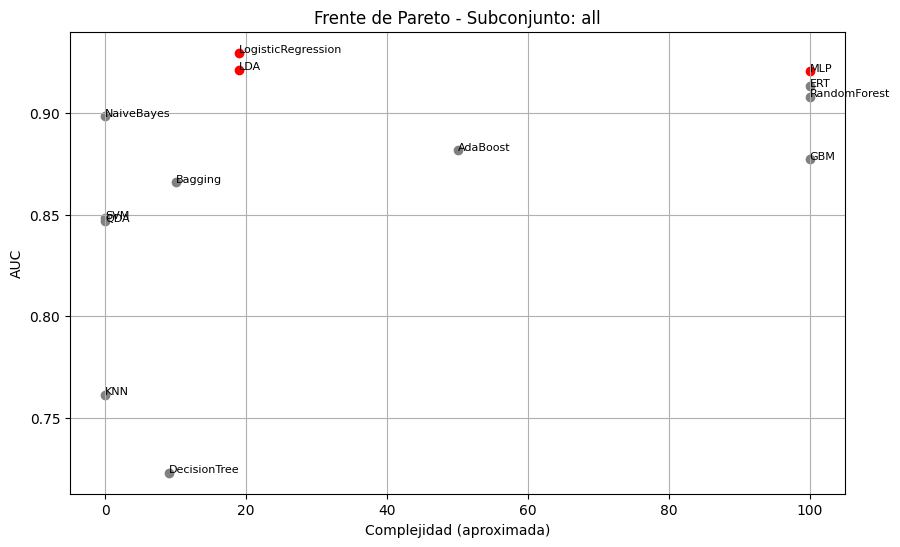

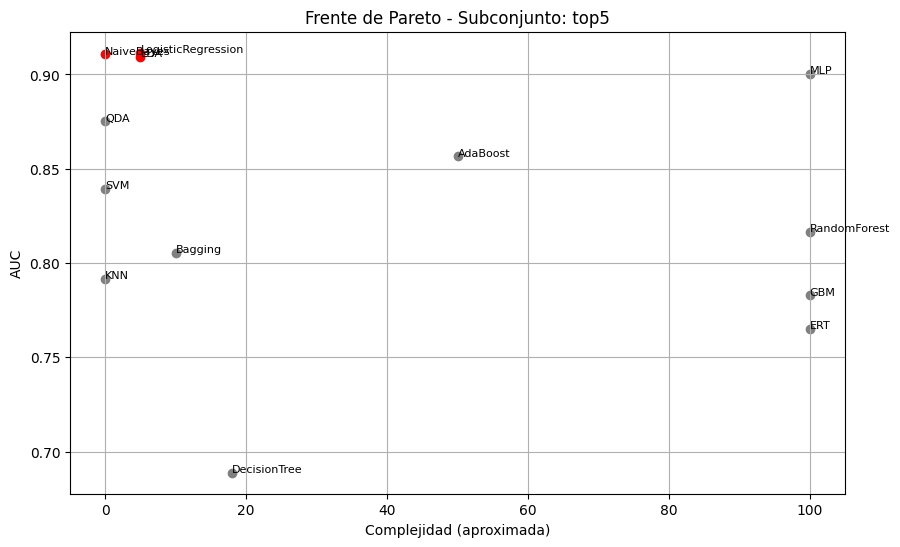

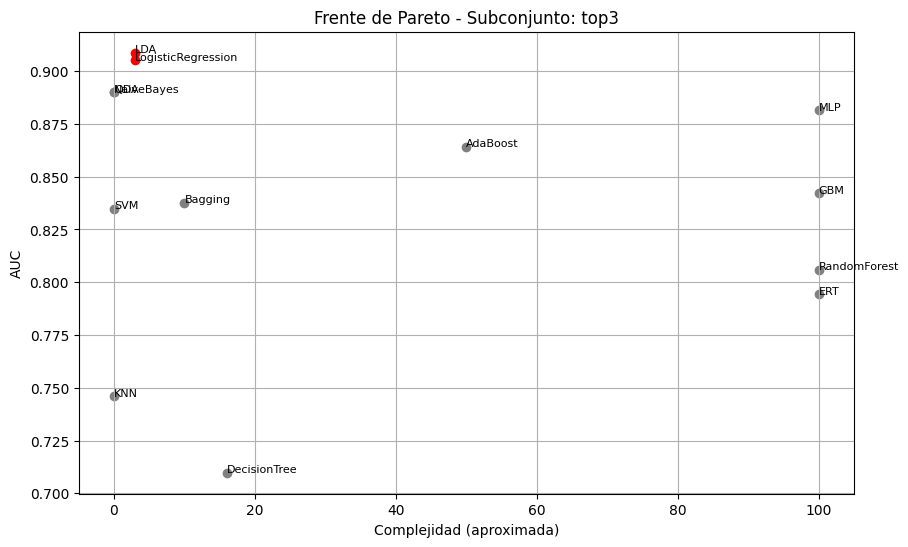

In [24]:
for subset_name in rashomon_df['Subset'].unique():
    subset_data = rashomon_df[rashomon_df['Subset'] == subset_name]

    plt.figure(figsize=(10, 6))
    for _, row in subset_data.iterrows():
        color = 'red' if row['WithinEpsilon'] else 'gray'
        plt.scatter(row['Complexity'], row['AUC'], label=row['Model'], color=color)
        plt.text(row['Complexity'], row['AUC'], row['Model'], fontsize=8)

    plt.title(f"Frente de Pareto - Subconjunto: {subset_name}")
    plt.xlabel("Complejidad (aproximada)")
    plt.ylabel("AUC")
    plt.grid(True)
    plt.show()


In [32]:
# ============================
# Paso Rashomon: Evaluación con distintos subconjuntos de atributos
# ============================

from sklearn.metrics import roc_auc_score
import time

# Definir subconjuntos basados en porcentajes del ranking de atributos
total_features = ranking_df.shape[0]
top_33_count = max(1, int(total_features * 0.33))
top_66_count = max(1, int(total_features * 0.66))

feature_sets = {
    'top33': ranking_df.sort_values("Rank").head(top_33_count).index.tolist(),
    'top66': ranking_df.sort_values("Rank").head(top_66_count).index.tolist(),
    'top100': ranking_df.sort_values("Rank").index.tolist()
}

rashomon_results = []
epsilon = 0.01  # 1% del mejor AUC

for subset_name, features in feature_sets.items():
    # Subset de datos
    X_sub = X[features]
    X_train_r, X_valid_r, y_train_r, y_valid_r = train_test_split(
        X_sub, y, test_size=0.25, stratify=y, random_state=42
    )

    subset_scores = []
    best_auc = 0

    for model_label, model in models.items():
        try:
            start = time.time()
            model.fit(X_train_r, y_train_r)
            train_time = time.time() - start

            # Predicciones
            try:
                y_prob = model.predict_proba(X_valid_r)[:, 1]
            except AttributeError:
                try:
                    y_prob = model.decision_function(X_valid_r)
                    # Escalar decision_function a [0,1] si es necesario
                    y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
                except AttributeError:
                    y_prob = model.predict(X_valid_r)  # último recurso (menos preciso)

            auc = roc_auc_score(y_valid_r, y_prob)
            best_auc = max(best_auc, auc)

            # Complejidad aproximada
            if hasattr(model, 'n_estimators'):
                complexity = model.n_estimators
            elif hasattr(model, 'coef_'):
                complexity = model.coef_.shape[1]
            elif hasattr(model, 'hidden_layer_sizes'):
                complexity = sum(model.hidden_layer_sizes)
            elif hasattr(model, 'tree_'):
                complexity = model.tree_.max_depth
            else:
                complexity = X_train_r.shape[1]  # fallback: nº de features

            subset_scores.append({
                'Subset': subset_name,
                'Model': model_label,
                'AUC': auc,
                'TrainingTime': train_time,
                'Complexity': complexity
            })
        except Exception as e:
            print(f'⚠️ Error con {model_label} en {subset_name}: {e}')

    # Determinar Rashomon set para este subset
    rashomon_models = [s for s in subset_scores if s['AUC'] >= (best_auc - epsilon)]
    rashomon_volume = len(rashomon_models)

    for score in subset_scores:
        score['BestAUC'] = best_auc
        score['RashomonVolume'] = rashomon_volume
        score['WithinEpsilon'] = score['AUC'] >= (best_auc - epsilon)

    rashomon_results.extend(subset_scores)

# DataFrame consolidado
rashomon_df = pd.DataFrame(rashomon_results)
rashomon_df


,Subset,Model,AUC,TrainingTime,Complexity,BestAUC,RashomonVolume,WithinEpsilon
0,top33,AdaBoost,0.856098,0.126710,50.0,0.886063,2,False
1,top33,Bagging,0.854007,0.026843,10.0,0.886063,2,False
2,top33,GBM,0.823345,0.144140,100.0,0.886063,2,False
3,top33,ERT,0.840070,0.126163,100.0,0.886063,2,False
4,top33,RandomForest,0.838676,0.160909,100.0,0.886063,2,False
5,top33,XGB,0.873868,0.112057,NaN,0.886063,2,False
6,top33,LogisticRegression,0.881185,0.027774,6.0,0.886063,2,True
7,top33,NaiveBayes,0.851916,0.001507,6.0,0.886063,2,False
8,top33,MLP,0.886063,0.108793,100.0,0.886063,2,True
9,top33,KNN,0.786411,0.002005,6.0,0.886063,2,False


In [33]:
# Identificar modelos en el frente de Pareto (AUC vs. Complejidad)

def is_pareto_efficient(df, perf_col="AUC", cost_col="Complexity"):
    is_efficient = []
    for i, row_i in df.iterrows():
        dominated = False
        for j, row_j in df.iterrows():
            if (
                (row_j[perf_col] >= row_i[perf_col])
                and (row_j[cost_col] <= row_i[cost_col])
                and ((row_j[perf_col] > row_i[perf_col]) or (row_j[cost_col] < row_i[cost_col]))
            ):
                dominated = True
                break
        is_efficient.append(not dominated)
    return is_efficient

# Aplicar por subconjunto
pareto_df_list = []
for subset in rashomon_df['Subset'].unique():
    df_subset = rashomon_df[rashomon_df['Subset'] == subset].copy()
    df_subset['ParetoFront'] = is_pareto_efficient(df_subset)
    pareto_df_list.append(df_subset)

pareto_df = pd.concat(pareto_df_list)

# Exportar modelos en el frente de Pareto
pareto_df[pareto_df['ParetoFront']].to_csv("rashomon_pareto_models.csv", index=False)
print("Modelos en el frente de Pareto exportados como 'rashomon_pareto_models.csv'")
pareto_df[pareto_df['ParetoFront']]




Modelos en el frente de Pareto exportados como 'rashomon_pareto_models.csv'


,Subset,Model,AUC,TrainingTime,Complexity,BestAUC,RashomonVolume,WithinEpsilon,ParetoFront
5,top33,XGB,0.873868,0.112057,NaN,0.886063,2,False,True
6,top33,LogisticRegression,0.881185,0.027774,6.0,0.886063,2,True,True
8,top33,MLP,0.886063,0.108793,100.0,0.886063,2,True,True
15,top66,Bagging,0.772474,0.063862,10.0,0.882578,3,False,True
18,top66,RandomForest,0.882578,0.164742,100.0,0.882578,3,True,True
19,top66,XGB,0.874564,0.070621,NaN,0.882578,3,True,True
26,top66,LDA,0.857143,0.003645,12.0,0.882578,3,False,True
29,top100,Bagging,0.806969,0.033571,10.0,0.878746,1,False,True
33,top100,XGB,0.852962,0.084283,NaN,0.878746,1,False,True
34,top100,LogisticRegression,0.850174,0.279357,19.0,0.878746,1,False,True


In [34]:


# Crear resumen por subconjunto
summary = rashomon_df.groupby('Subset').agg({
    'RashomonVolume': 'first',
    'AUC': ['mean', 'max'],
    'Complexity': 'mean'
}).reset_index()

summary.columns = ['Subset', 'RashomonVolume', 'AUC_Mean', 'AUC_Max', 'Complexity_Mean']
summary = summary.sort_values("Subset")

# Mostrar con formato
display(summary.style.format({
    "AUC_Mean": "{:.3f}",
    "AUC_Max": "{:.3f}",
    "Complexity_Mean": "{:.1f}"
}))

,Subset,RashomonVolume,AUC_Mean,AUC_Max,Complexity_Mean
0,top100,1,0.789,0.879,44.8
1,top33,2,0.826,0.886,39.5
2,top66,3,0.812,0.883,41.8


In [35]:
# Exportar resumen a CSV
summary.to_csv("rashomon_summary.csv", index=False)
print("Resumen exportado como 'rashomon_summary_HeartDisease.csv'")

Resumen exportado como 'rashomon_summary_HeartDisease.csv'


In [ ]:
# Exportar todos los resultados individuales a CSV
rashomon_df.to_csv("rashomon_model_results_heartDisease.csv", index=False)
print("Resultados detallados exportados como 'rashomon_model_results_HeartDisease.csv'")


Resultados detallados exportados como 'rashomon_model_results_HeartDisease.csv'


In [29]:
# Identificar modelos en el frente de Pareto (AUC vs. Complejidad)
def is_pareto_efficient(df, perf_col="AUC", cost_col="Complexity"):
    is_efficient = []
    for i, row_i in df.iterrows():
        dominated = False
        for j, row_j in df.iterrows():
            if (
                (row_j[perf_col] >= row_i[perf_col])
                and (row_j[cost_col] <= row_i[cost_col])
                and ((row_j[perf_col] > row_i[perf_col]) or (row_j[cost_col] < row_i[cost_col]))
            ):
                dominated = True
                break
        is_efficient.append(not dominated)
    return is_efficient

# Aplicar por subconjunto
pareto_df_list = []
for subset in rashomon_df['Subset'].unique():
    df_subset = rashomon_df[rashomon_df['Subset'] == subset].copy()
    df_subset['ParetoFront'] = is_pareto_efficient(df_subset)
    pareto_df_list.append(df_subset)

pareto_df = pd.concat(pareto_df_list)

# Exportar modelos en el frente de Pareto
pareto_df[pareto_df['ParetoFront']].to_csv("rashomon_pareto_models.csv", index=False)
print("Modelos en el frente de Pareto exportados como 'rashomon_pareto_models.csv'")

Modelos en el frente de Pareto exportados como 'rashomon_pareto_models.csv'


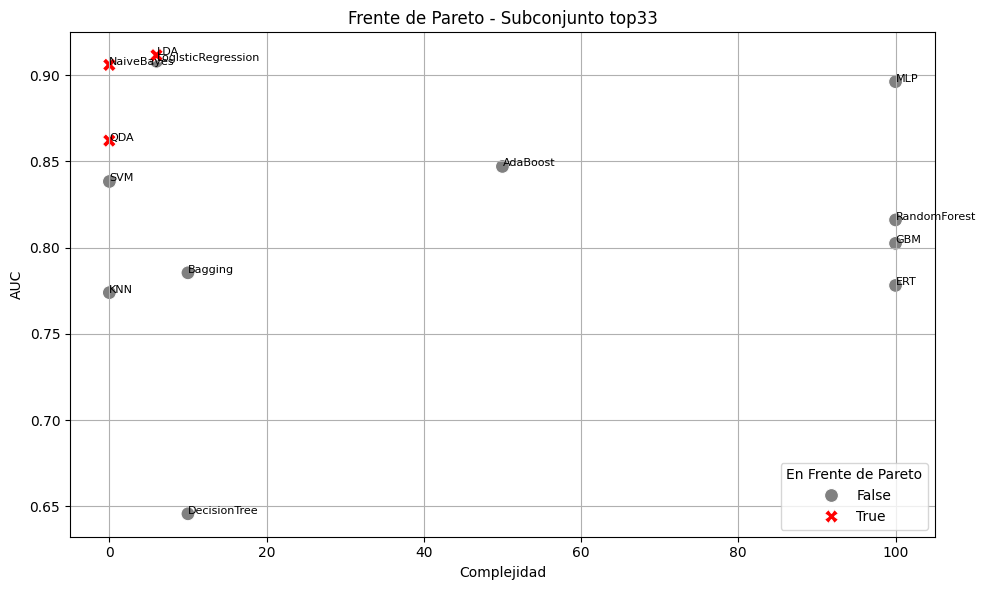

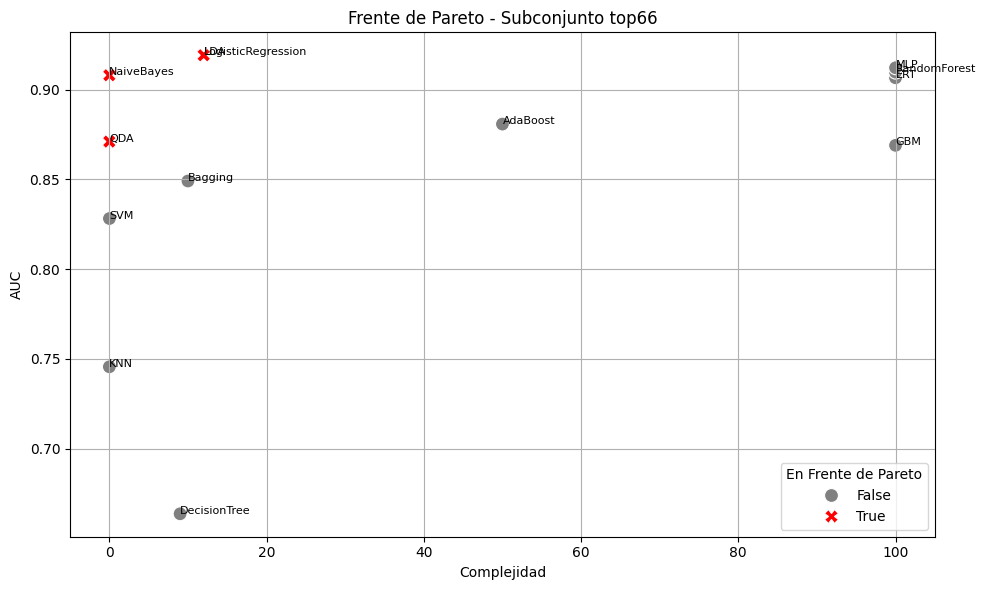

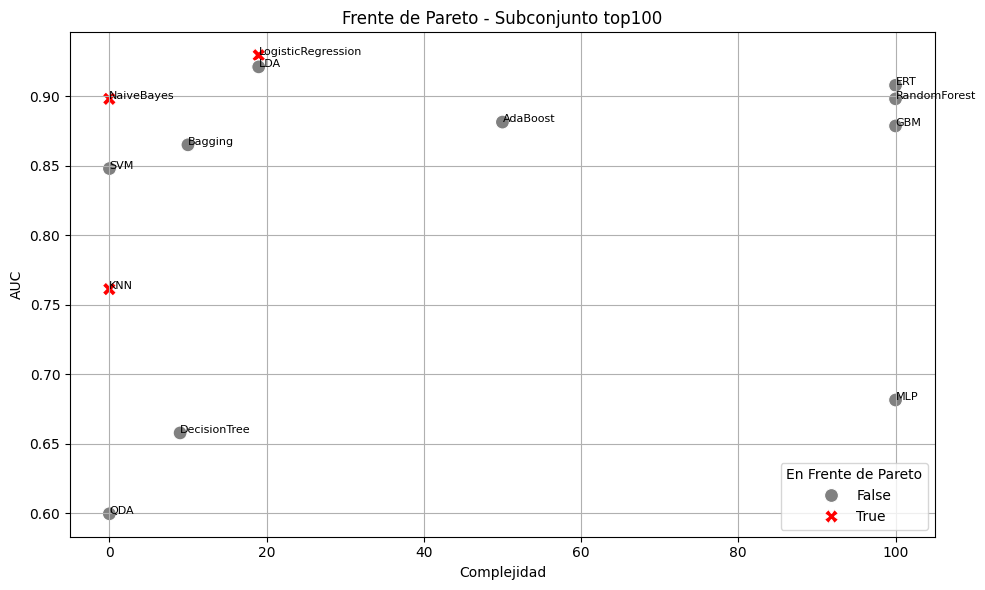

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualización del frente de Pareto para cada subconjunto
for subset in pareto_df['Subset'].unique():
    data = pareto_df[pareto_df['Subset'] == subset]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='Complexity', y='AUC',
        hue='ParetoFront',
        style='ParetoFront',
        palette={True: 'red', False: 'gray'},
        data=data,
        s=100
    )
    for _, row in data.iterrows():
        plt.text(row['Complexity'], row['AUC'], row['Model'], fontsize=8)

    plt.title(f'Frente de Pareto - Subconjunto {subset}')
    plt.xlabel('Complejidad')
    plt.ylabel('AUC')
    plt.legend(title='En Frente de Pareto')
    plt.grid(True)
    plt.tight_layout()
    plt.show()